In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-13 16:01:57.586411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-30(i) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/D-30/Device-30(i)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[-0.0234375+0.0703125j  0.0625   -0.015625j  -0.0234375+0.0078125j ...
  0.0078125+0.015625j   0.015625 +0.03125j    0.0625   -0.0078125j]
2048
85185
(2048, 85185)
[0.02900163 0.01708401 0.00599894 ... 0.00538724 0.00599033 0.01664416]
0
(10000, 2048)
(10000,)
[ 0.0390625+0.0390625j -0.0546875-0.0078125j  0.03125  +0.0546875j ...
  0.       -0.015625j  -0.046875 -0.0078125j -0.015625 -0.0625j   ]
2048
80241
(2048, 80241)
[0.0295978  0.01722668 0.00870225 ... 0.00930543 0.00755128 0.01796037]
1
(20000, 2048)
(20000,)
[ 0.0546875-0.0234375j  0.03125  -0.046875j  -0.0234375-0.0234375j ...
  0.       -0.015625j   0.03125  -0.0390625j -0.0078125+0.j       ]
2048
71316
(2048, 71316)
[0.0293704  0.01623967 0.00537395 ... 0.00561898 0.00598221 0.01678048]
2
(30000, 2048)
(30000,)
[-0.015625 -0.0078125j -0.046875 -0.046875j  -0.03125  -0.015625j  ...
  0.0078125+0.0390625j -0.0390625-0.046875j   0.0234375+0.j       ]
2048
75268
(2048, 75268)
[0.02902174 0.01629172 0.00577534 ... 0.00521284 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-30(i) dataset 

In [7]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

In [8]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 4.5528 - accuracy: 0.1245
test loss, test acc: [4.55278205871582, 0.12449999898672104]


In [9]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[1 1 1 ... 5 5 5]
1
[[ 448    3  934   27 2111 6393   82    2]
 [   0  179 9737    2    0   63    3   16]
 [  19    1 2264    8  382 7243   83    0]
 [ 757    0 1137    0 4404 3693    9    0]
 [   7    0 3561  386  355 5191  493    7]
 [  60    0 2638   33  588 6653   26    2]
 [ 329    0  767    2 1123 7726   52    1]
 [ 107    0 2545 1368  410 5424  137    9]]
              precision    recall  f1-score   support

           0       0.26      0.04      0.08     10000
           1       0.98      0.02      0.04     10000
           2       0.10      0.23      0.13     10000
           3       0.00      0.00      0.00     10000
           4       0.04      0.04      0.04     10000
           5       0.16      0.67      0.25     10000
           6       0.06      0.01      0.01     10000
           7       0.24      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.23      0.12  

Test Accuracy:0.1245


Text(0.5, 1.0, 'Accuracy:0.124')

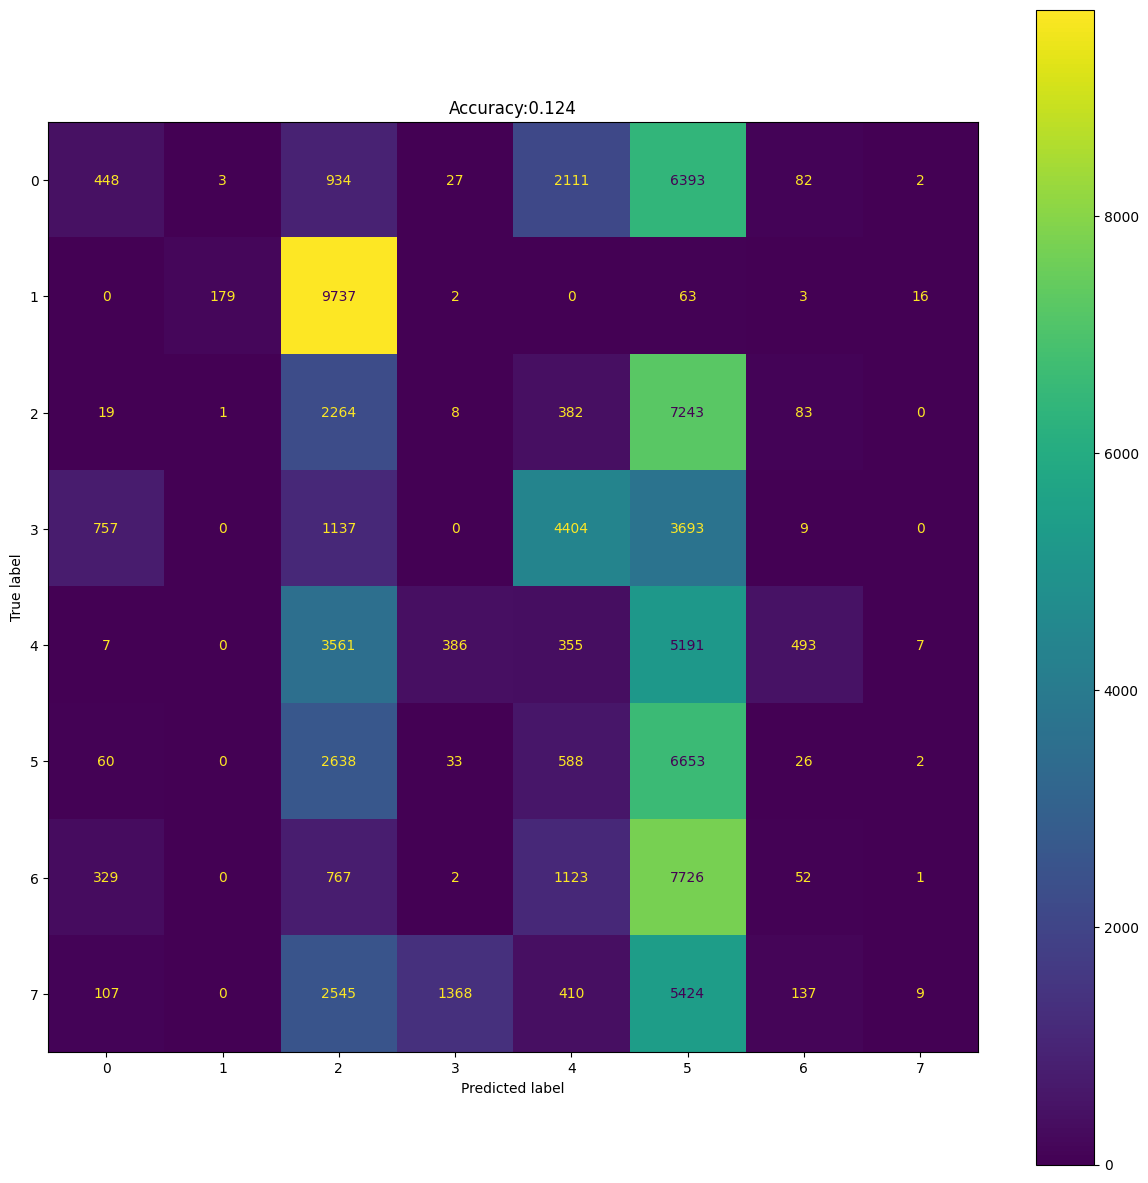

In [10]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

Nordic Device-25(i) model to Nordic Device-30(i) dataset 

In [11]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [12]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [13]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.4202 - accuracy: 0.2604
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5428 - accuracy: 0.4146
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3169 - accuracy: 0.5128
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2076 - accuracy: 0.5584
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1402 - accuracy: 0.5865
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.0941 - accuracy: 0.6064
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.0604 - accuracy: 0.6198
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.0349 - accuracy: 0.6309
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0144 - accuracy: 0.6388
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0

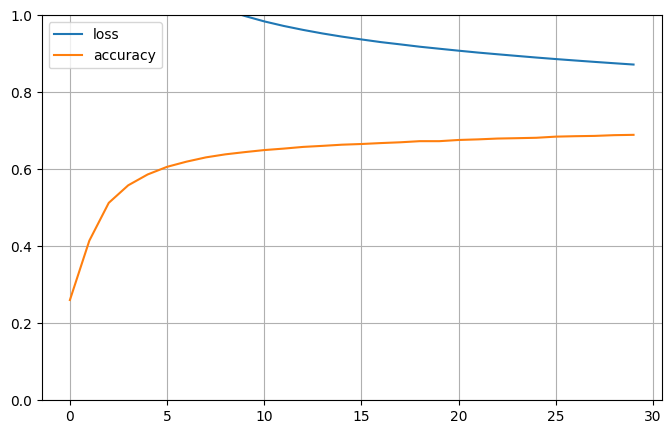

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [15]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.8692 - accuracy: 0.6914
test loss, test acc: [0.8691904544830322, 0.6913874745368958]


In [16]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[1 1 1 ... 7 7 7]
1
[[6098    4  540  462  708 1251  852   85]
 [   0 9724   14    0  201   22    1   38]
 [ 548   55 4728  206 1030 1874 1251  308]
 [ 249    0  159 8252    3  177 1152    8]
 [ 515  149  605    2 7721  610   32  366]
 [1013   47 1618  242 1032 5012  845  191]
 [1003   57 1379 1473  156 1103 4732   97]
 [  64   32  140   27  285  251  157 9044]]
              precision    recall  f1-score   support

           0       0.64      0.61      0.63     10000
           1       0.97      0.97      0.97     10000
           2       0.51      0.47      0.49     10000
           3       0.77      0.83      0.80     10000
           4       0.69      0.77      0.73     10000
           5       0.49      0.50      0.49     10000
           6       0.52      0.47      0.50     10000
           7       0.89      0.90      0.90     10000

    accuracy                           0.69     80000
   macro avg       0.69      0.69  

Test Accuracy:0.6913875


Text(0.5, 1.0, 'Accuracy:0.691')

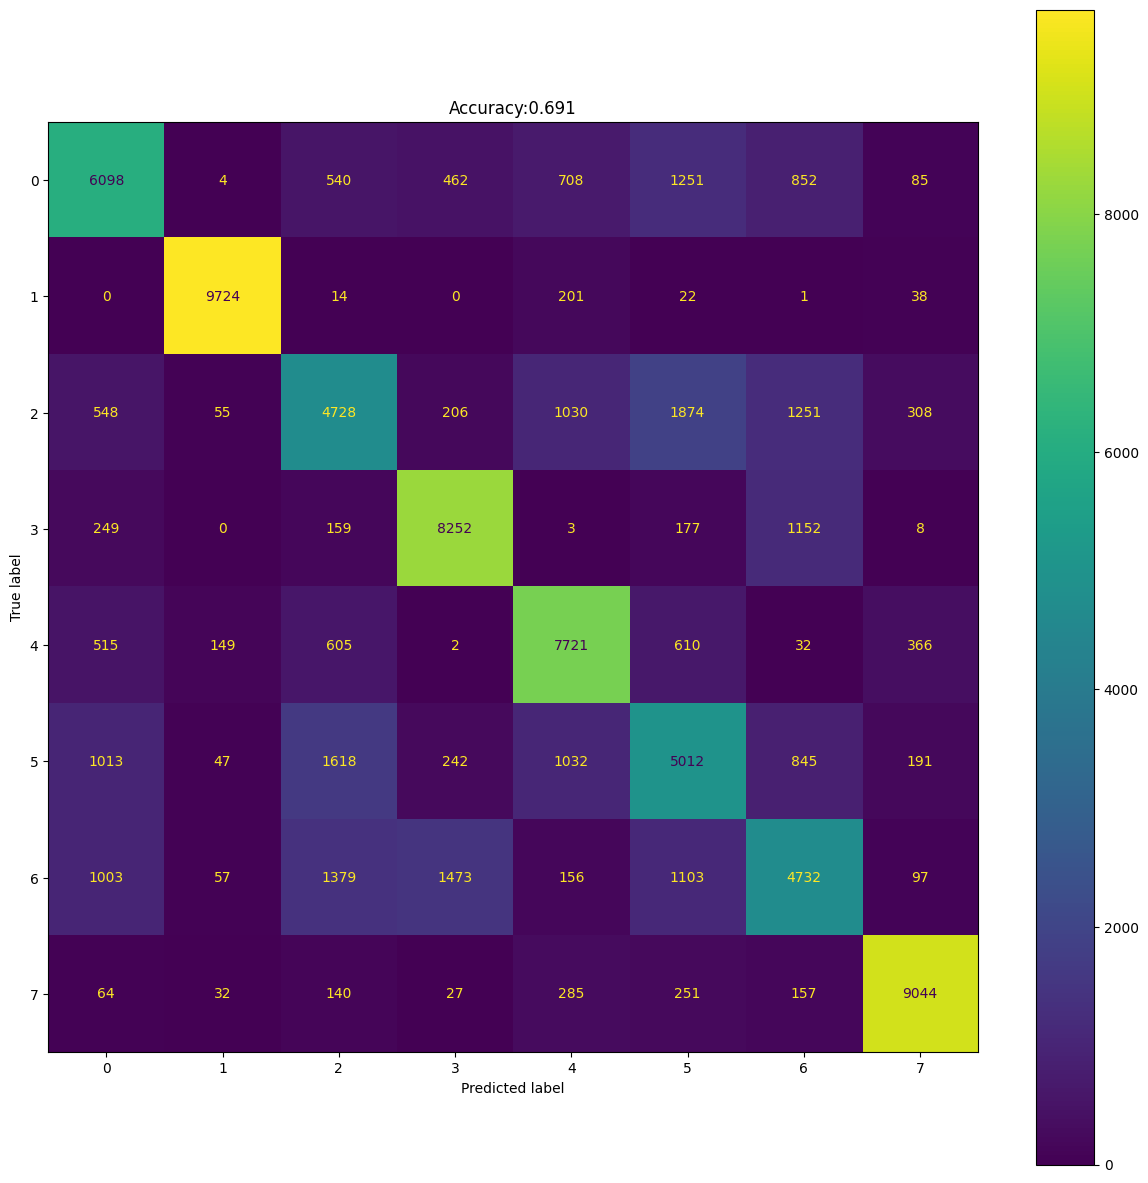

In [17]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-25(ii) model to Nordic Device-30(i) dataset 

In [18]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [19]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 7.0617 - accuracy: 0.1336
test loss, test acc: [7.061706066131592, 0.1335500031709671]


In [20]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 3 3 ... 6 6 2]
3
[[ 494    1 1387    3   52 8042   12    9]
 [   1   10 1340   12    0  478 8108   51]
 [ 232    0 3165    0    5 6493   96    9]
 [5173    0 1506    0  553 2702    0   66]
 [   0    1 4931    2    0 4451  614    1]
 [ 262    2 2848    0   14 6776   56   42]
 [1854    2  967    0   50 7040   34   53]
 [  16    0 5216   42   99 2065 2357  205]]
              precision    recall  f1-score   support

           0       0.06      0.05      0.05     10000
           1       0.62      0.00      0.00     10000
           2       0.15      0.32      0.20     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.18      0.68      0.28     10000
           6       0.00      0.00      0.00     10000
           7       0.47      0.02      0.04     10000

    accuracy                           0.13     80000
   macro avg       0.19      0.13  

Test Accuracy:0.13355


Text(0.5, 1.0, 'Accuracy:0.134')

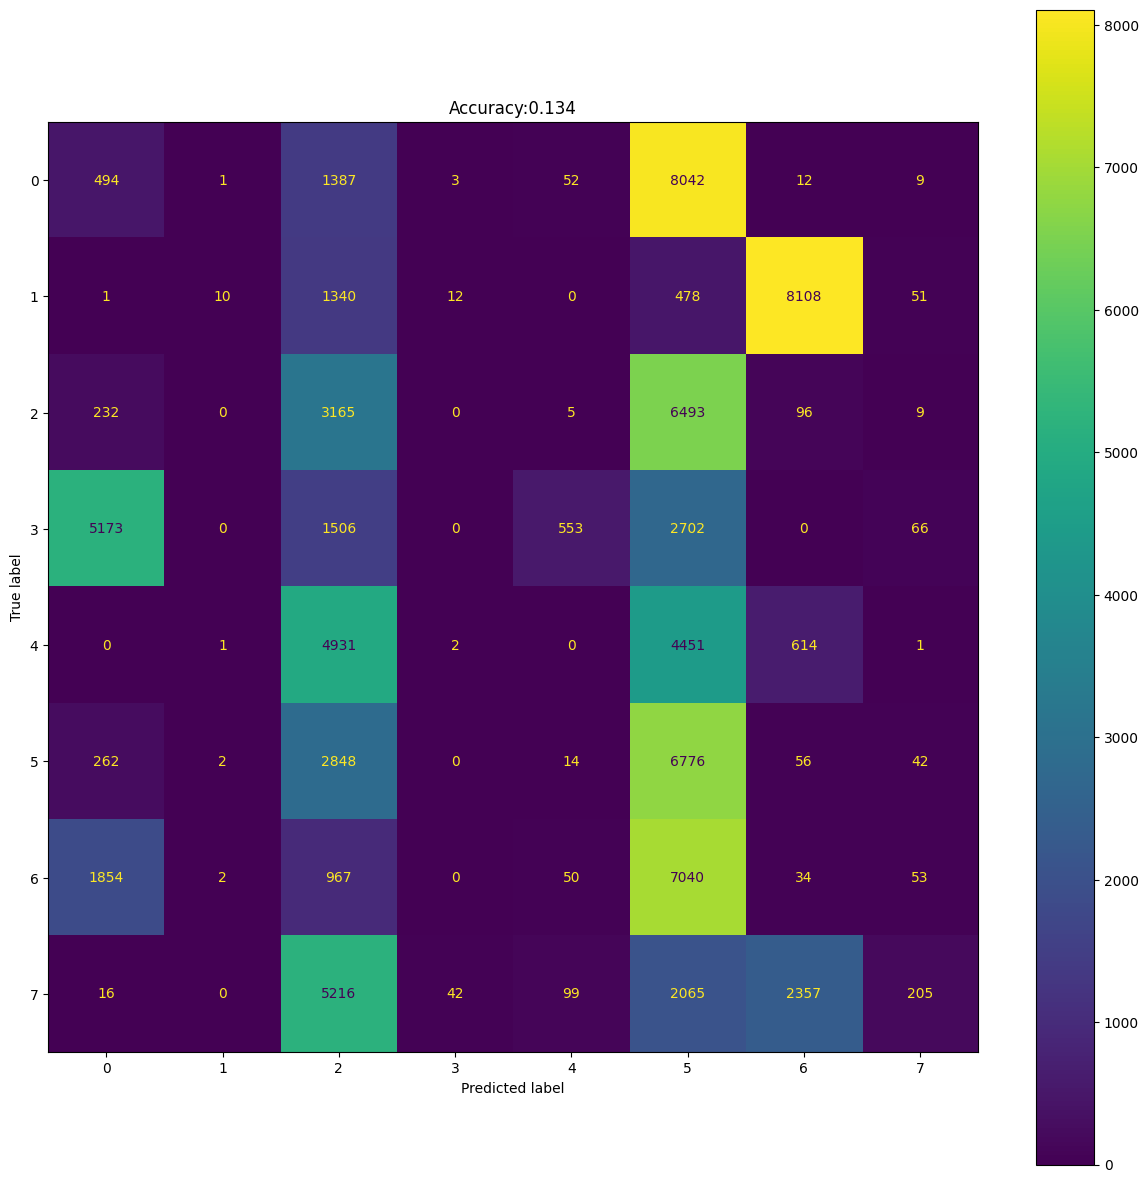

In [21]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [22]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [23]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [24]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.4210 - accuracy: 0.2636
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.4285 - accuracy: 0.4306
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2796 - accuracy: 0.4932
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2089 - accuracy: 0.5313
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1668 - accuracy: 0.5562
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1375 - accuracy: 0.5711
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1153 - accuracy: 0.5850
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0967 - accuracy: 0.5932
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0811 - accuracy: 0.6021
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss

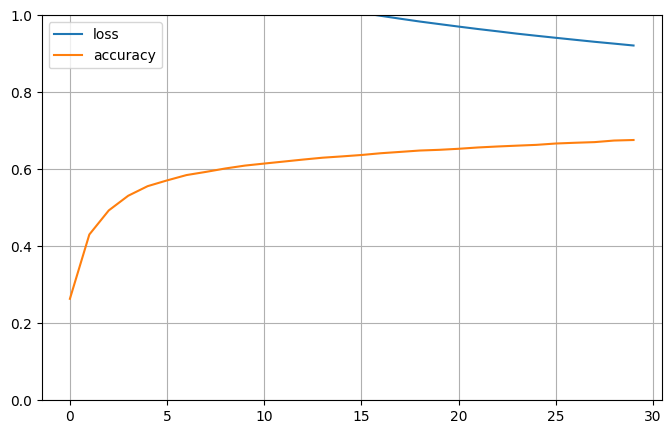

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [26]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.9189 - accuracy: 0.6758
test loss, test acc: [0.9189392328262329, 0.675849974155426]


In [27]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[1 1 1 ... 7 7 7]
1
[[5688    6  531  601  631 1198 1299   46]
 [   0 9841    2    0   29   97    1   30]
 [ 983   37 3527  387  812 2329 1406  519]
 [ 229    1  279 8150    1  178 1123   39]
 [ 379  135  397    0 7563  658   36  832]
 [ 640   82  834  322  600 6454  864  204]
 [ 849   25  787 1704   97 1166 5241  131]
 [  23  128  248  263 1071  420  243 7604]]
              precision    recall  f1-score   support

           0       0.65      0.57      0.61     10000
           1       0.96      0.98      0.97     10000
           2       0.53      0.35      0.42     10000
           3       0.71      0.81      0.76     10000
           4       0.70      0.76      0.73     10000
           5       0.52      0.65      0.57     10000
           6       0.51      0.52      0.52     10000
           7       0.81      0.76      0.78     10000

    accuracy                           0.68     80000
   macro avg       0.67      0.68   

Test Accuracy:0.67585


Text(0.5, 1.0, 'Accuracy:0.676')

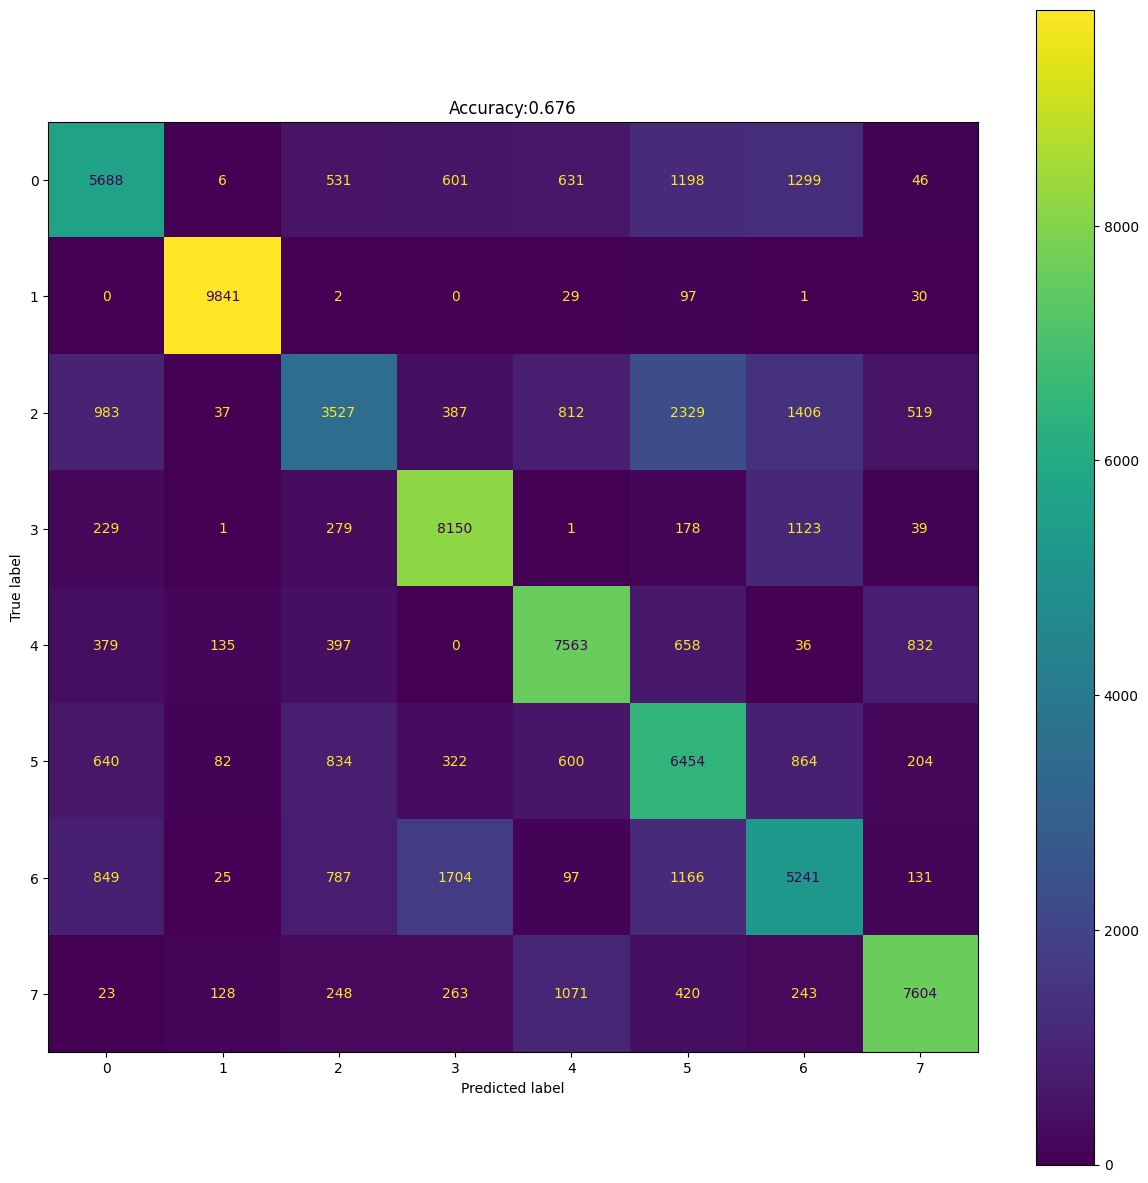

In [28]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-30(i) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

2023-04-13 16:16:12.827295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 3.9887 - accuracy: 0.1654
test loss, test acc: [3.988739490509033, 0.16536250710487366]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 4 4 ... 5 6 5]
4
[[ 565   44 1657  299 1474 5589  256  116]
 [   0 1386 7028   73    0    3 1422   88]
 [ 453   65  906  140  577 7325  481   53]
 [ 246  514  840   97   57 6308 1860   78]
 [ 242   10  678  222 2091 6599   60   98]
 [ 537   44 1238  150  453 7066  437   75]
 [ 304   65 1660  159  414 6858  381  159]
 [ 170  264  648 1208  213 5700 1060  737]]
              precision    recall  f1-score   support

           0       0.22      0.06      0.09     10000
           1       0.58      0.14      0.22     10000
           2       0.06      0.09      0.07     10000
           3       0.04      0.01      0.02     10000
           4       0.40      0.21      0.27     10000
           5       0.16      0.71      0.25     10000
           6       0.06      0.04      0.05     10000
           7       0.52      0.07      0.13     10000

    accuracy                           0.17     80000
   macro avg       0.26      0.17  

Test Accuracy:0.1653625


Text(0.5, 1.0, 'Accuracy:0.165')

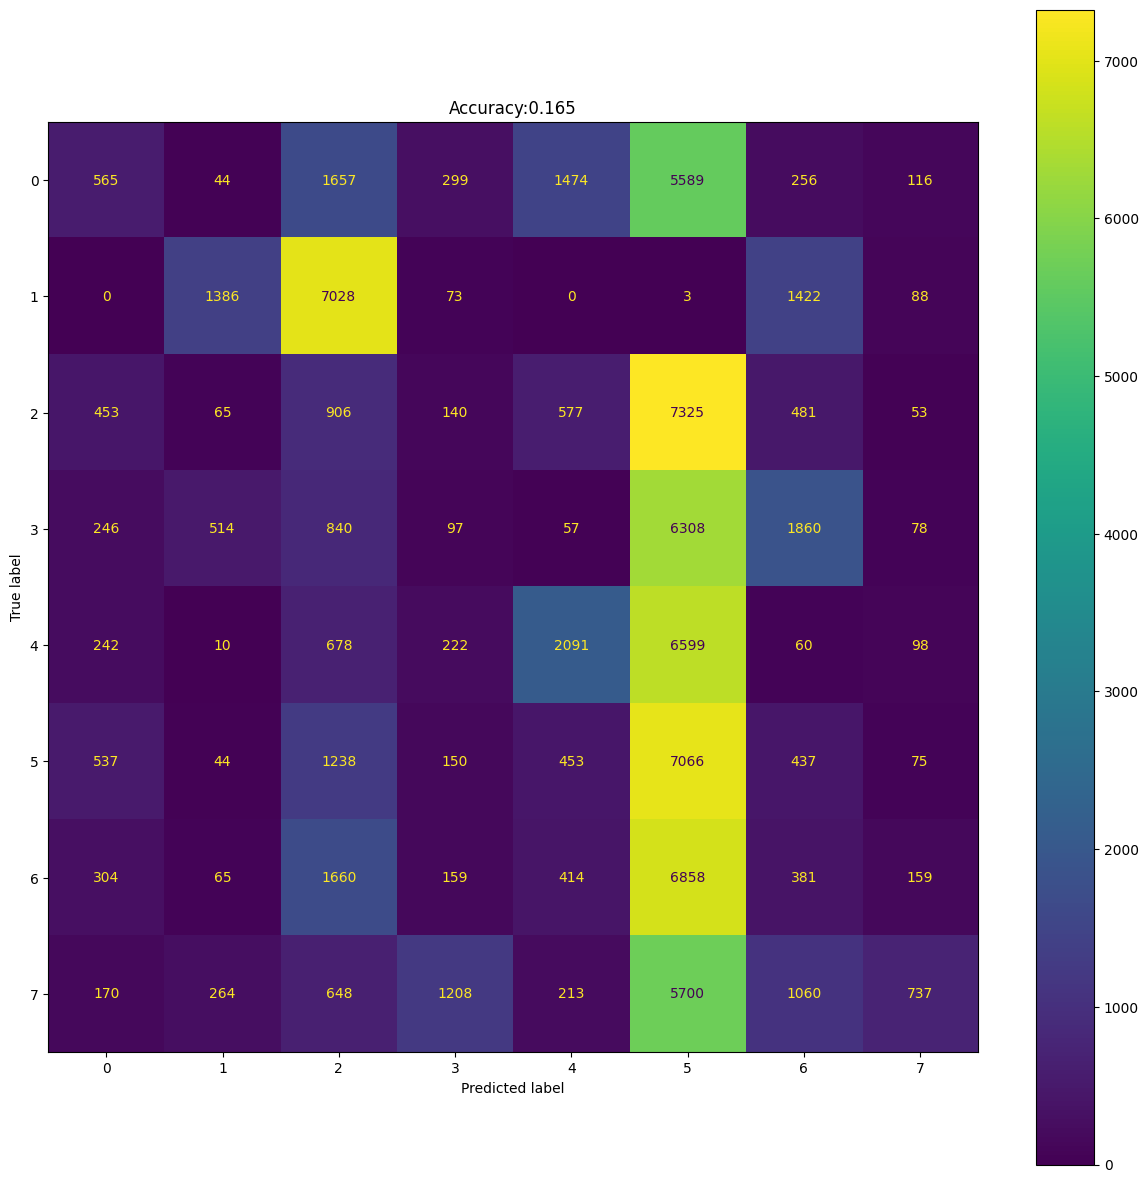

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(iii) model to Nordic Device-30(i) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.5629 - accuracy: 0.2593
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8136 - accuracy: 0.3392
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5818 - accuracy: 0.3848
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5027 - accuracy: 0.4147
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4659 - accuracy: 0.4299
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4434 - accuracy: 0.4400
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4265 - accuracy: 0.4476
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4127 - accuracy: 0.4545
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4009 - accuracy: 0.4615
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

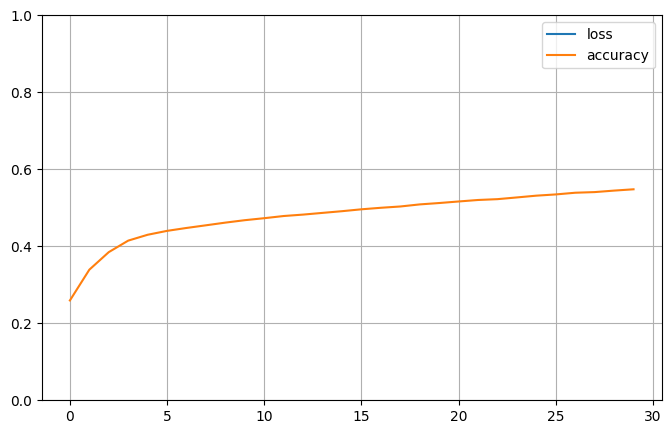

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2443 - accuracy: 0.5485
test loss, test acc: [1.2442920207977295, 0.5484750270843506]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[4 4 4 ... 7 7 7]
4
[[4186   43  562  567 2428  584 1174  456]
 [   5 9869    0   55    0    0    6   65]
 [1140   23 2478 1585 1429 1200 1582  563]
 [ 244  167  425 6948  212  386  747  871]
 [1330    7  397  217 6361  346  880  462]
 [1010   33  892 1263 1303 2977 1968  554]
 [ 833   42  575  978 1203  906 4628  835]
 [ 340  111  156 1449  566  155  792 6431]]
              precision    recall  f1-score   support

           0       0.46      0.42      0.44     10000
           1       0.96      0.99      0.97     10000
           2       0.45      0.25      0.32     10000
           3       0.53      0.69      0.60     10000
           4       0.47      0.64      0.54     10000
           5       0.45      0.30      0.36     10000
           6       0.39      0.46      0.43     10000
           7       0.63      0.64      0.64     10000

    accuracy                           0.55     80000
   macro avg       0.54      0.55   

Test Accuracy:0.548475


Text(0.5, 1.0, 'Accuracy:0.548')

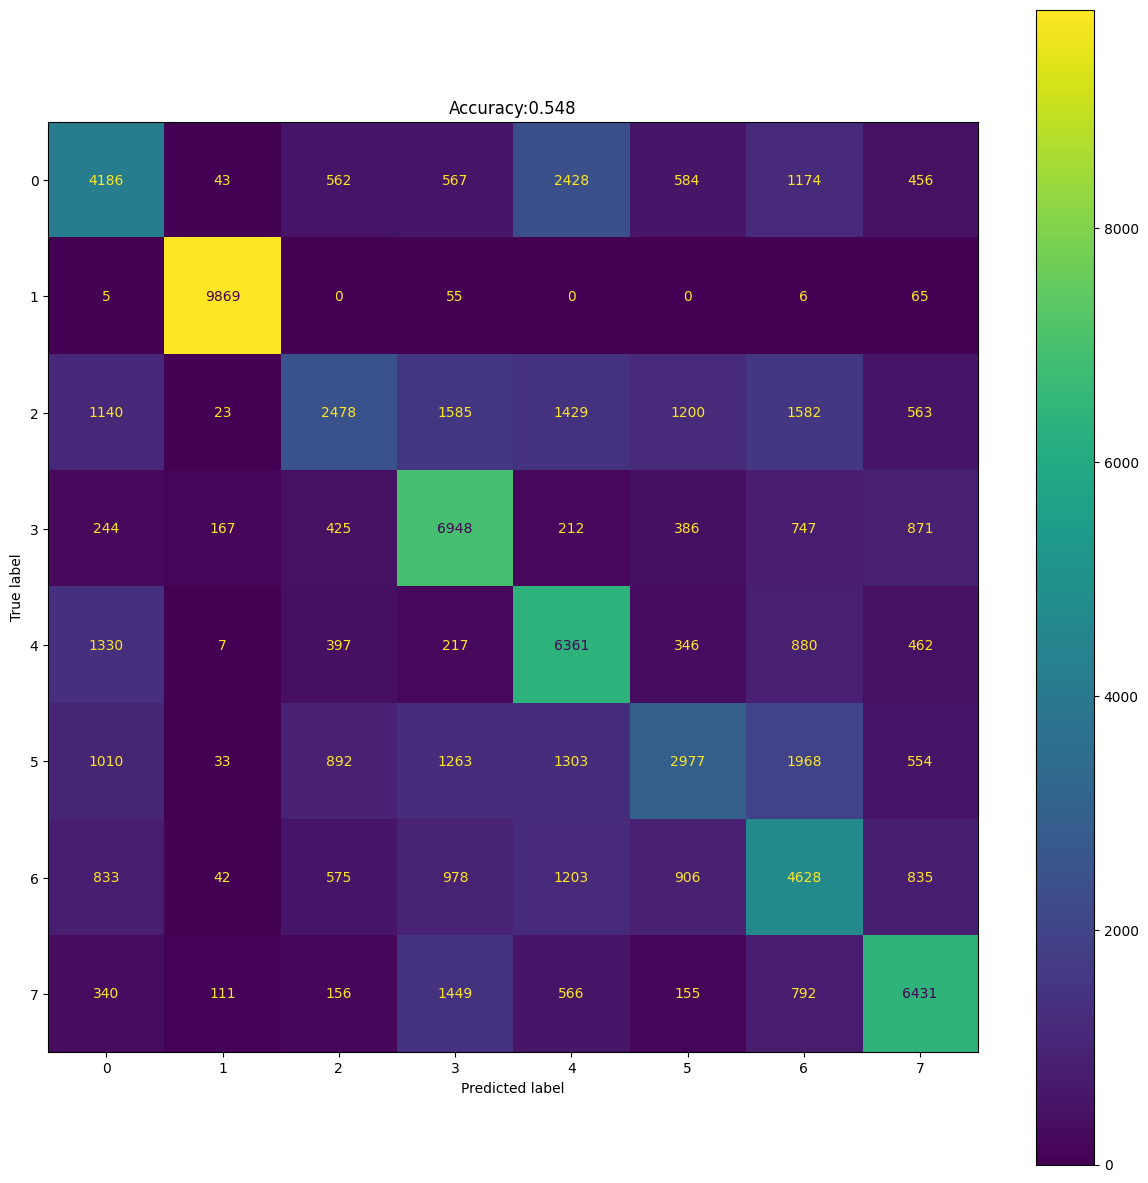

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-30(i) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 4.5668 - accuracy: 0.1273
test loss, test acc: [4.566847324371338, 0.12726250290870667]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[2 5 3 ... 3 5 5]
2
[[1227    5  592  331  377 7372   35   61]
 [1867   81  179  217    3 2649 4953   51]
 [1137    9 1195  120  810 6102  348  279]
 [2108   78  606   34  204 6007  807  156]
 [1773    1  260  294  509 7054   31   78]
 [ 844   13 1087   80  753 6746  283  194]
 [1301    3  610  128  920 6611  233  194]
 [1498    2  320  218  132 7339  335  156]]
              precision    recall  f1-score   support

           0       0.10      0.12      0.11     10000
           1       0.42      0.01      0.02     10000
           2       0.25      0.12      0.16     10000
           3       0.02      0.00      0.01     10000
           4       0.14      0.05      0.07     10000
           5       0.14      0.67      0.23     10000
           6       0.03      0.02      0.03     10000
           7       0.13      0.02      0.03     10000

    accuracy                           0.13     80000
   macro avg       0.15      0.13  

Test Accuracy:0.1272625


Text(0.5, 1.0, 'Accuracy:0.127')

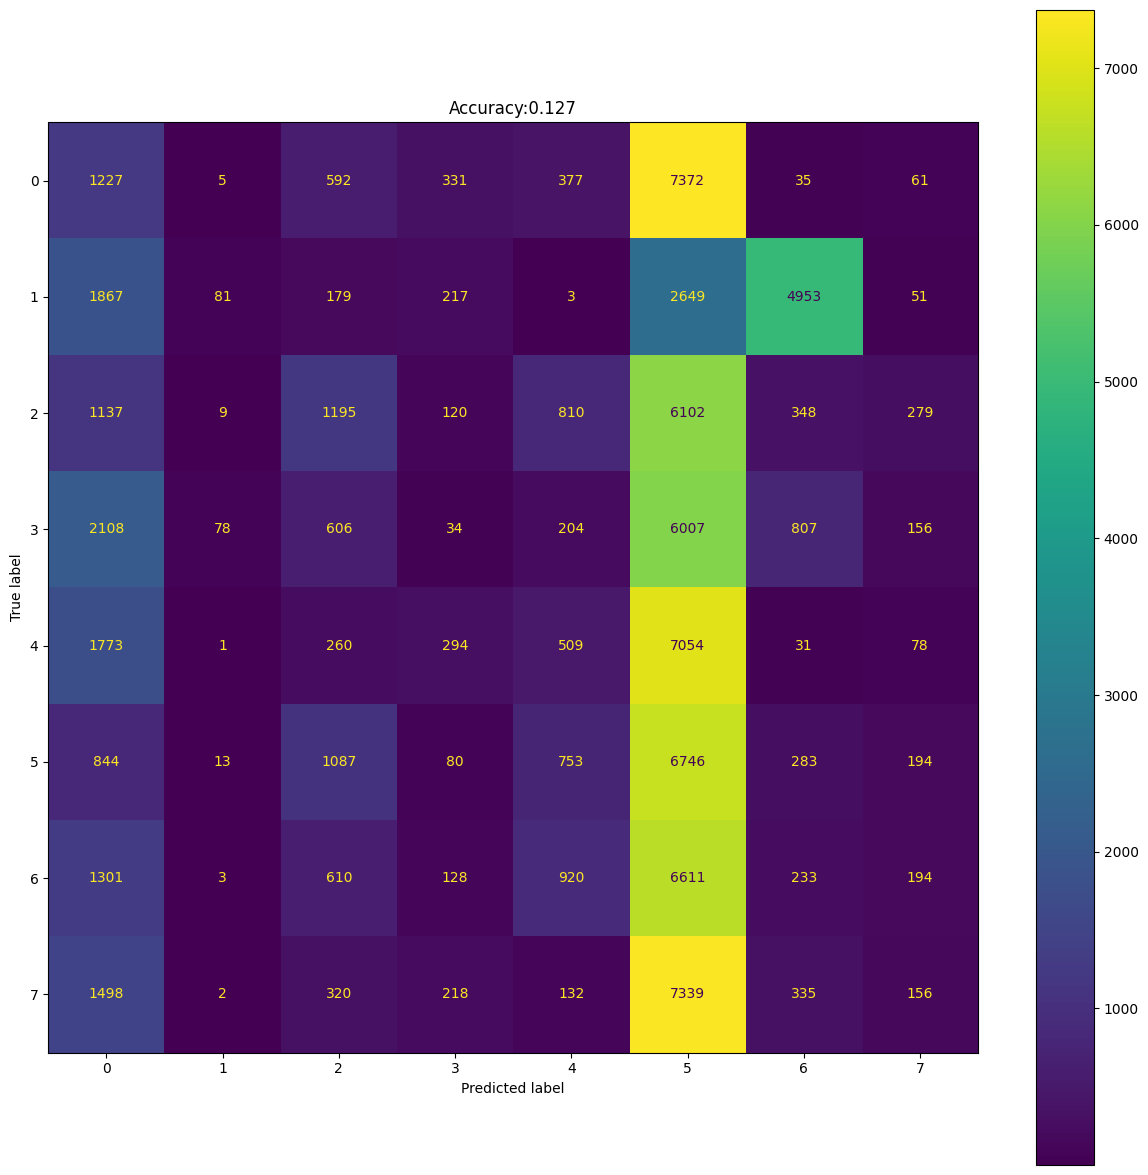

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8626 - accuracy: 0.1706
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9665 - accuracy: 0.2753
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6862 - accuracy: 0.3521
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5934 - accuracy: 0.3887
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5501 - accuracy: 0.4073
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5230 - accuracy: 0.4203
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5038 - accuracy: 0.4286
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4884 - accuracy: 0.4353
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4754 - accuracy: 0.4421
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

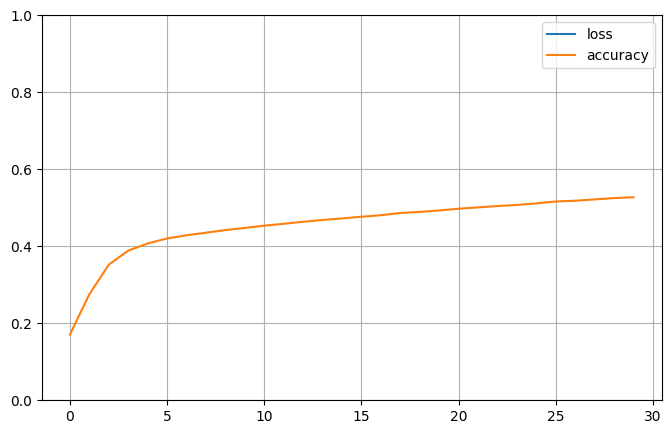

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.3126 - accuracy: 0.5337
test loss, test acc: [1.3126355409622192, 0.5337250232696533]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[0 4 4 ... 0 7 7]
0
[[4620   30  531  577 2251 1029  586  376]
 [   2 9381   25  188    2    4    4  394]
 [ 950   90 3203 1573  679 1801 1089  615]
 [ 394  479  679 6380  166  856  515  531]
 [1763   36  486  415 5593  669  565  473]
 [1118   59 1445 1474  540 3862 1071  431]
 [1171   56 1375 1229 1042 1324 2984  819]
 [ 372  364  493  876  421  258  541 6675]]
              precision    recall  f1-score   support

           0       0.44      0.46      0.45     10000
           1       0.89      0.94      0.92     10000
           2       0.39      0.32      0.35     10000
           3       0.50      0.64      0.56     10000
           4       0.52      0.56      0.54     10000
           5       0.39      0.39      0.39     10000
           6       0.41      0.30      0.34     10000
           7       0.65      0.67      0.66     10000

    accuracy                           0.53     80000
   macro avg       0.52      0.53   

Test Accuracy:0.533725


Text(0.5, 1.0, 'Accuracy:0.534')

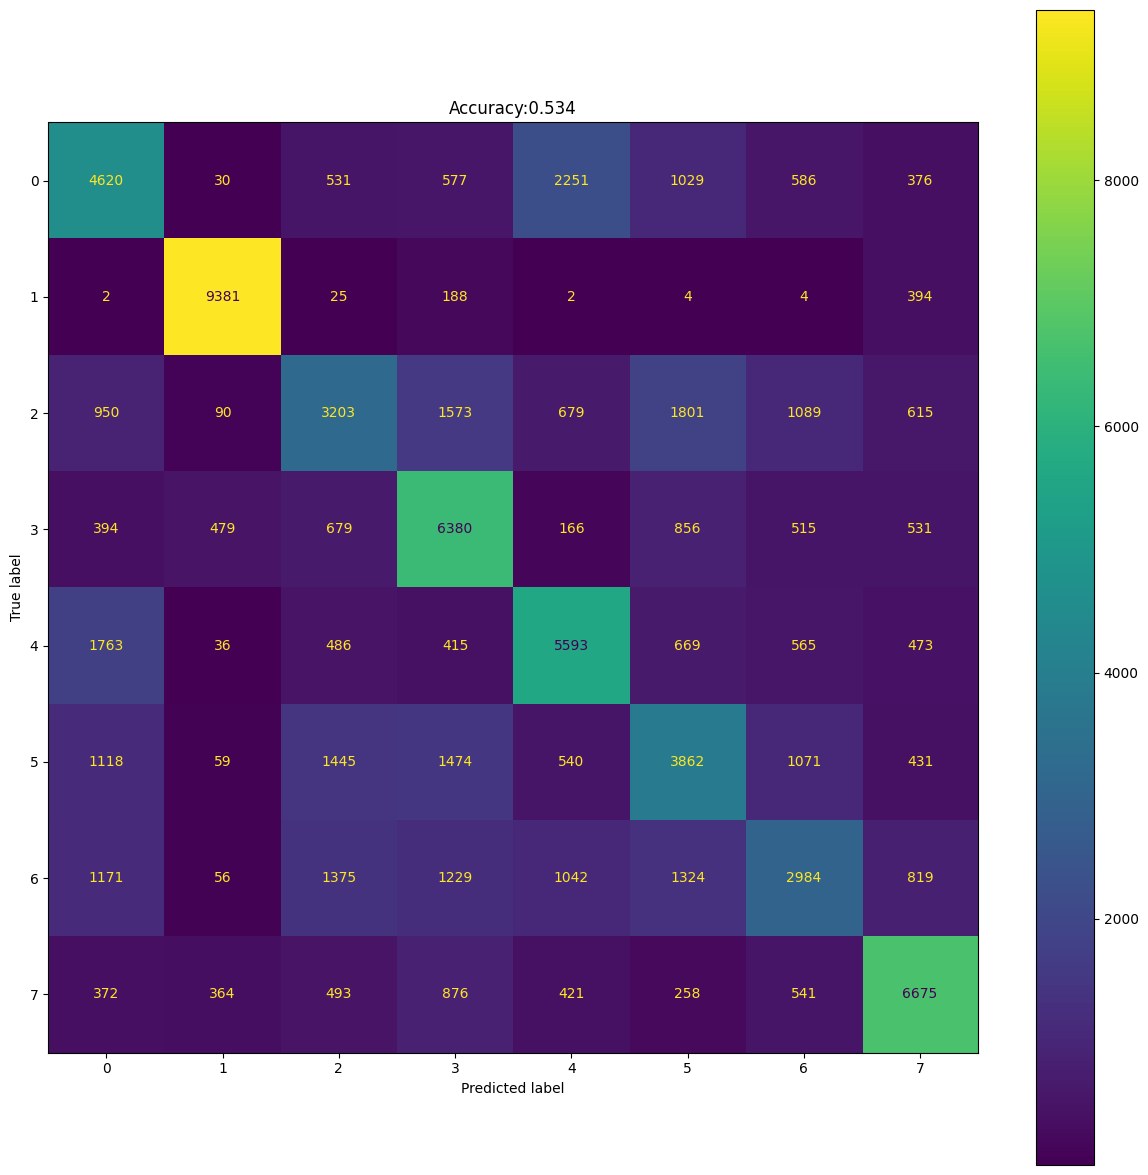

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-30(i) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 5ms/step - loss: 4.6828 - accuracy: 0.1469
test loss, test acc: [4.682807445526123, 0.1469375044107437]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 2 2 ... 5 5 5]
4
[[ 638    0  339  158  874 7982    7    2]
 [ 112  618 3336  358  164 4921  453   38]
 [  77    7  946  285  469 8158   19   39]
 [  28  100  504  168  341 8638   75  146]
 [ 690    0  215  187 1106 7795    5    2]
 [ 338    6  890  213  689 7840   13   11]
 [  60    4  640  255  819 8127   13   82]
 [  10   36 1075  465  338 7538  112  426]]
              precision    recall  f1-score   support

           0       0.33      0.06      0.11     10000
           1       0.80      0.06      0.11     10000
           2       0.12      0.09      0.11     10000
           3       0.08      0.02      0.03     10000
           4       0.23      0.11      0.15     10000
           5       0.13      0.78      0.22     10000
           6       0.02      0.00      0.00     10000
           7       0.57      0.04      0.08     10000

    accuracy                           0.15     80000
   macro avg       0.28      0.15  

Test Accuracy:0.1469375


Text(0.5, 1.0, 'Accuracy:0.147')

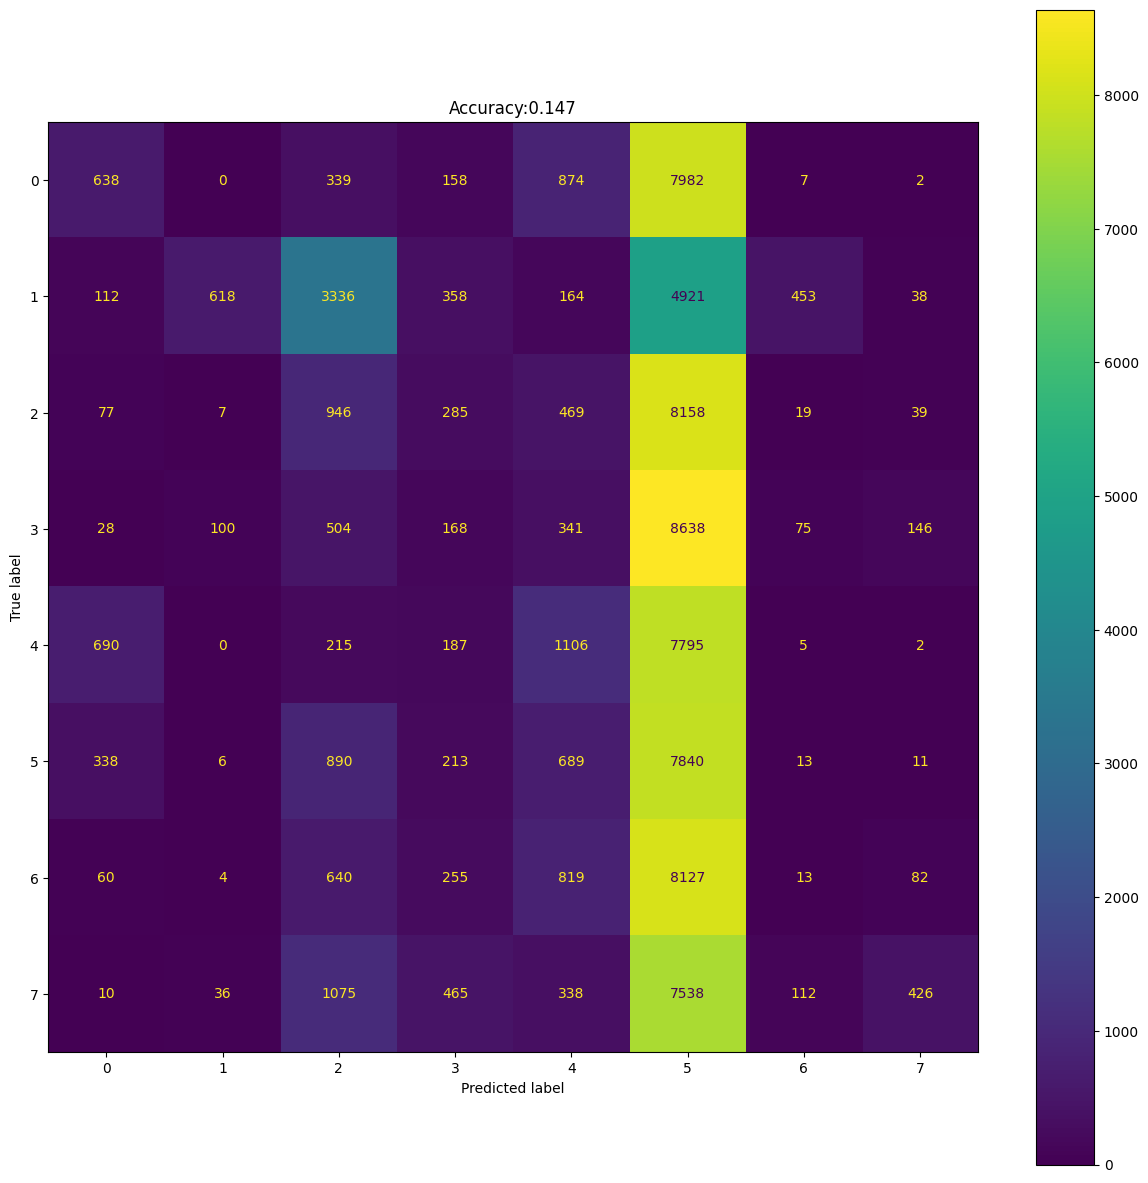

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-30(i) dataset 

In [30]:
model = keras.models.load_model("//Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.6062 - accuracy: 0.2321
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9066 - accuracy: 0.2913
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7182 - accuracy: 0.3308
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6464 - accuracy: 0.3602
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6057 - accuracy: 0.3850
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5763 - accuracy: 0.4006
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5525 - accuracy: 0.4154
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5317 - accuracy: 0.4275
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5141 - accuracy: 0.4376
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - lo

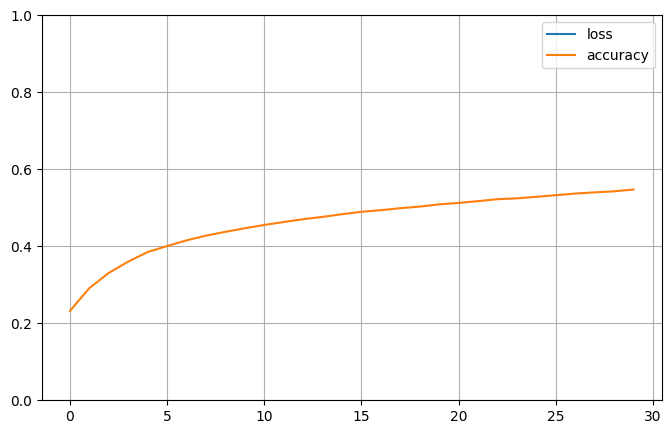

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.3004 - accuracy: 0.5493
test loss, test acc: [1.3004399538040161, 0.5492500066757202]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[4 5 2 ... 7 7 7]
4
[[4269   96 1121  298 2368 1217  477  154]
 [  19 9439   67   13   53   82   39  288]
 [ 594  292 4309  862  740 1695  797  711]
 [ 223  343  800 6302  189  648  646  849]
 [1432   79 1019  265 5750  867  411  177]
 [1071  196 2083  694  783 4234  617  322]
 [ 669  142 2249 1089  567 1524 2685 1075]
 [ 161  362  607  733  321  358  506 6952]]
              precision    recall  f1-score   support

           0       0.51      0.43      0.46     10000
           1       0.86      0.94      0.90     10000
           2       0.35      0.43      0.39     10000
           3       0.61      0.63      0.62     10000
           4       0.53      0.57      0.55     10000
           5       0.40      0.42      0.41     10000
           6       0.43      0.27      0.33     10000
           7       0.66      0.70      0.68     10000

    accuracy                           0.55     80000
   macro avg       0.55      0.55   

Test Accuracy:0.54925


Text(0.5, 1.0, 'Accuracy:0.549')

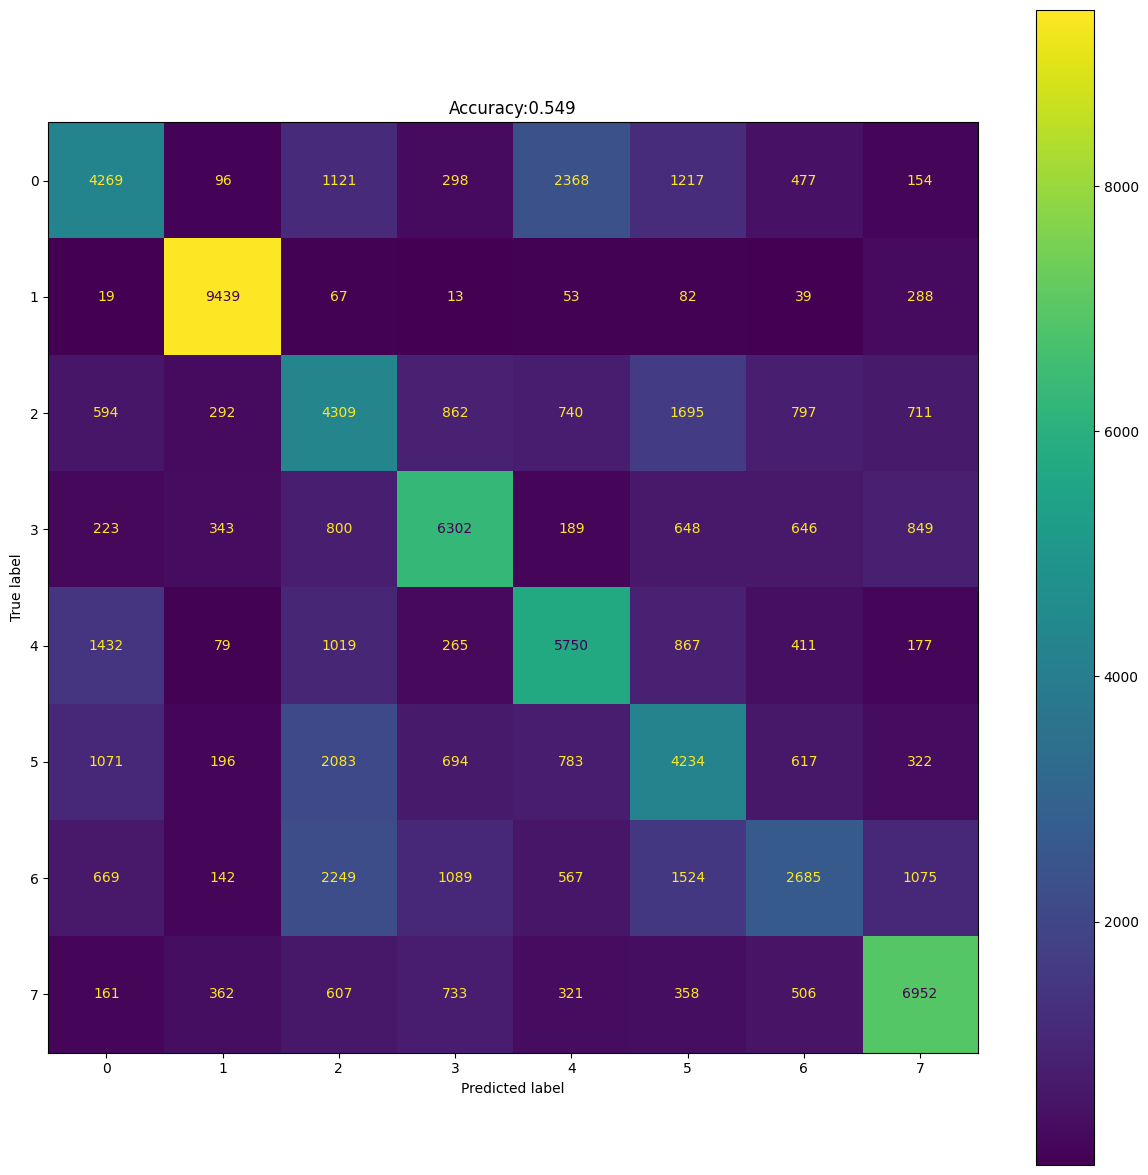

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Smae Device Other set of Models

Nordic Device-30(ii) model to Nordic Device-30(i) dataset 

In [29]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [30]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5986 - accuracy: 0.7990
test loss, test acc: [0.5985850691795349, 0.799049973487854]


In [31]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[4 4 4 ... 6 7 7]
4
[[7983    0    2    0 2013    2    0    0]
 [   0 9937   30    0    0   17   11    5]
 [  29    0 4596    2    0 4730  642    1]
 [   0    6   72 9780    0  129   11    2]
 [  77    0    0    0 9923    0    0    0]
 [ 925    0 1894    0    0 6784  397    0]
 [  12    1  799    2    0 4159 5024    3]
 [   0    4   46    3    0    1   49 9897]]
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     10000
           1       1.00      0.99      1.00     10000
           2       0.62      0.46      0.53     10000
           3       1.00      0.98      0.99     10000
           4       0.83      0.99      0.90     10000
           5       0.43      0.68      0.53     10000
           6       0.82      0.50      0.62     10000
           7       1.00      0.99      0.99     10000

    accuracy                           0.80     80000
   macro avg       0.82      0.80   

Test Accuracy:0.79905


Text(0.5, 1.0, 'Accuracy:0.799')

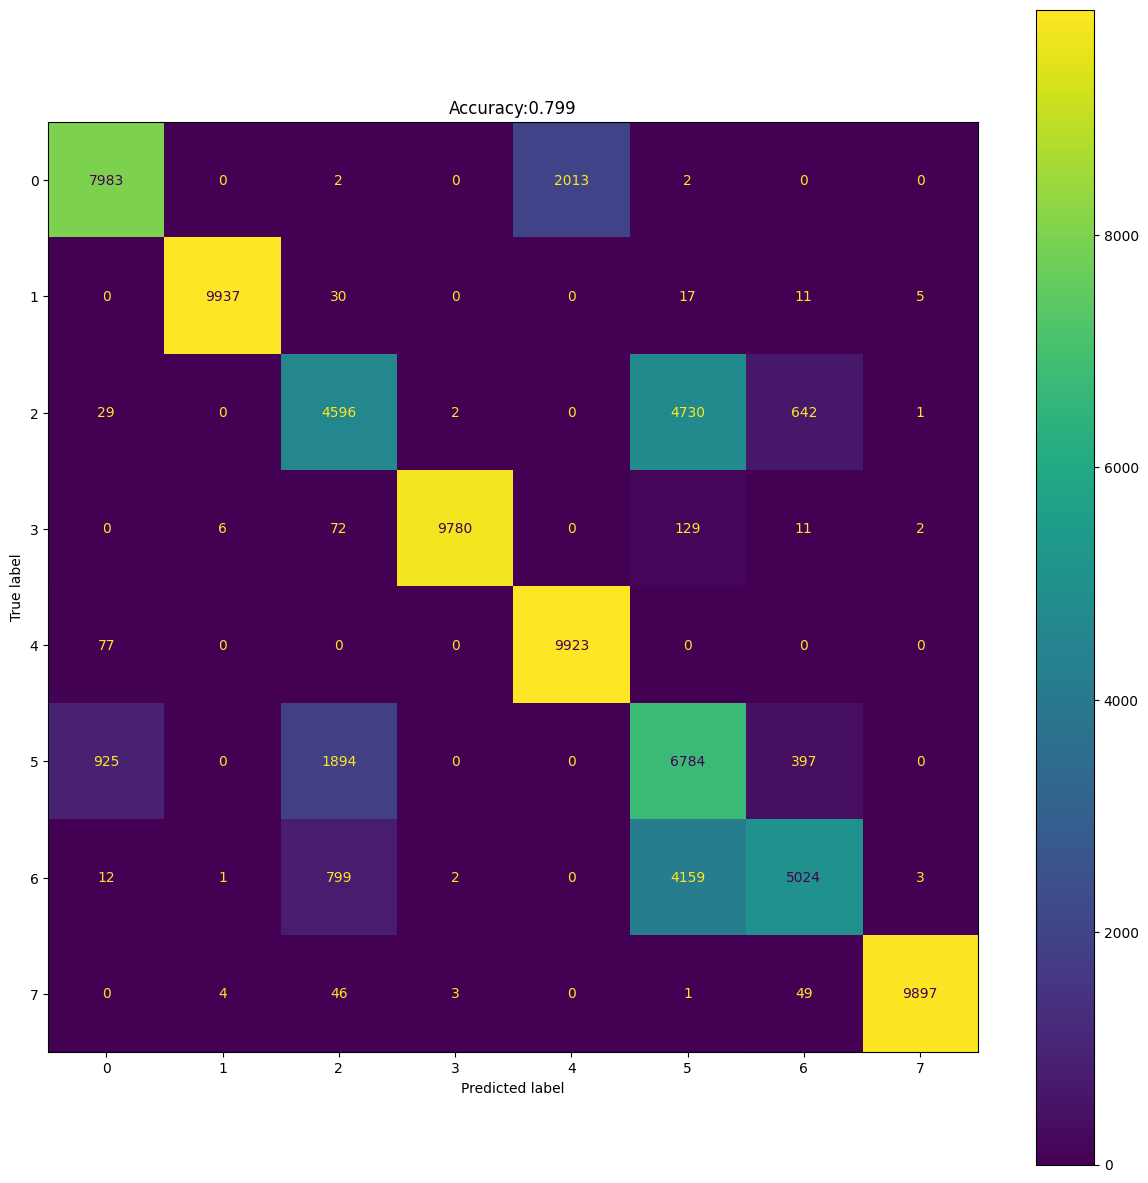

In [32]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other set of samples

In [33]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [34]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [35]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.4048 - accuracy: 0.8552
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3370 - accuracy: 0.8738
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3061 - accuracy: 0.8830
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2882 - accuracy: 0.8893
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2772 - accuracy: 0.8938
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2699 - accuracy: 0.8970
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2647 - accuracy: 0.8989
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2604 - accuracy: 0.9003
Epoch 9/30
2500/2500 [==============================] - 9s 3ms/step - loss: 0.2569 - accuracy: 0.9019
Epoch 10/30
2500/2500 [==============================] - 9s 3ms/step - loss: 

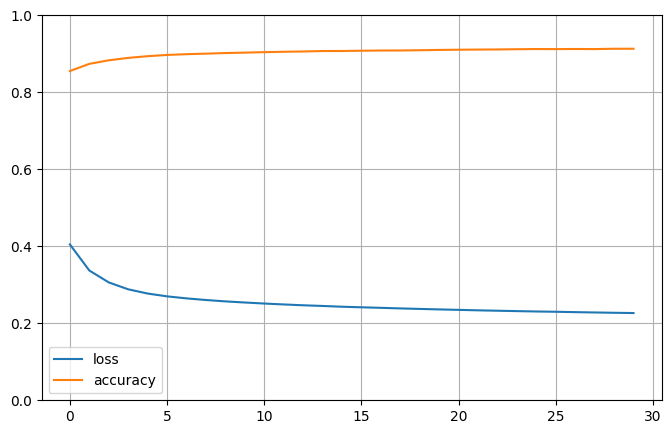

In [36]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [37]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2252 - accuracy: 0.9142
test loss, test acc: [0.2252252697944641, 0.9142125248908997]


In [38]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 4 4 ... 7 7 7]
4
[[9556    0    0    0  421   23    0    0]
 [   0 9949   29    1    0    8    8    5]
 [   2    6 7610   15    0 1111 1253    3]
 [   0    2   50 9947    0    0    1    0]
 [ 423    0    0    0 9577    0    0    0]
 [  43    0 1133    2    0 8362  460    0]
 [   0    1 1410   15    0  401 8166    7]
 [   0    5   12    1    0    0   12 9970]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       1.00      0.99      1.00     10000
           2       0.74      0.76      0.75     10000
           3       1.00      0.99      1.00     10000
           4       0.96      0.96      0.96     10000
           5       0.84      0.84      0.84     10000
           6       0.82      0.82      0.82     10000
           7       1.00      1.00      1.00     10000

    accuracy                           0.91     80000
   macro avg       0.91      0.91  

Test Accuracy:0.9142125


Text(0.5, 1.0, 'Accuracy:0.914')

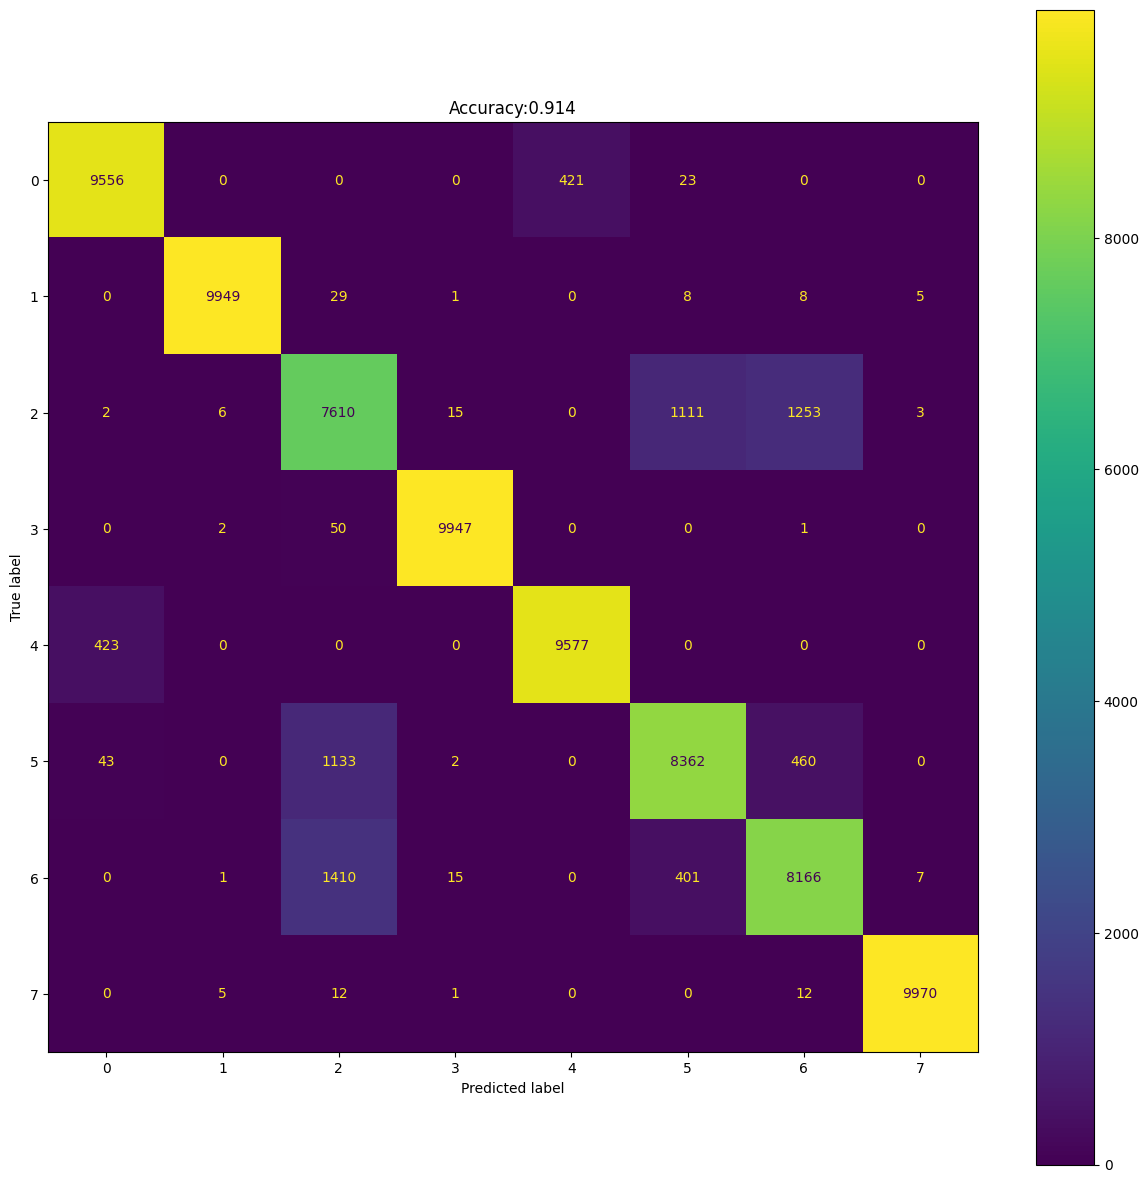

In [39]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-30(i) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 4.9076 - accuracy: 0.1189
test loss, test acc: [4.907560348510742, 0.11891250312328339]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[5 5 5 ... 4 4 4]
5
[[   0    0  378  260 1891 7188   22  261]
 [   0    0  435  871 7522  683  411   78]
 [  29    9 1164  211 1313 6851   86  337]
 [  20    6 1048  319 5197 3017  331   62]
 [   2    0  304  281  758 8271   24  360]
 [   7    1 1933  143  893 6685   75  263]
 [  52    4 1787  529  996 6100   93  439]
 [ 113   10  773  499 4164 3832  115  494]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.15      0.12      0.13     10000
           3       0.10      0.03      0.05     10000
           4       0.03      0.08      0.05     10000
           5       0.16      0.67      0.25     10000
           6       0.08      0.01      0.02     10000
           7       0.22      0.05      0.08     10000

    accuracy                           0.12     80000
   macro avg       0.09      0.12   

Test Accuracy:0.1189125


Text(0.5, 1.0, 'Accuracy:0.119')

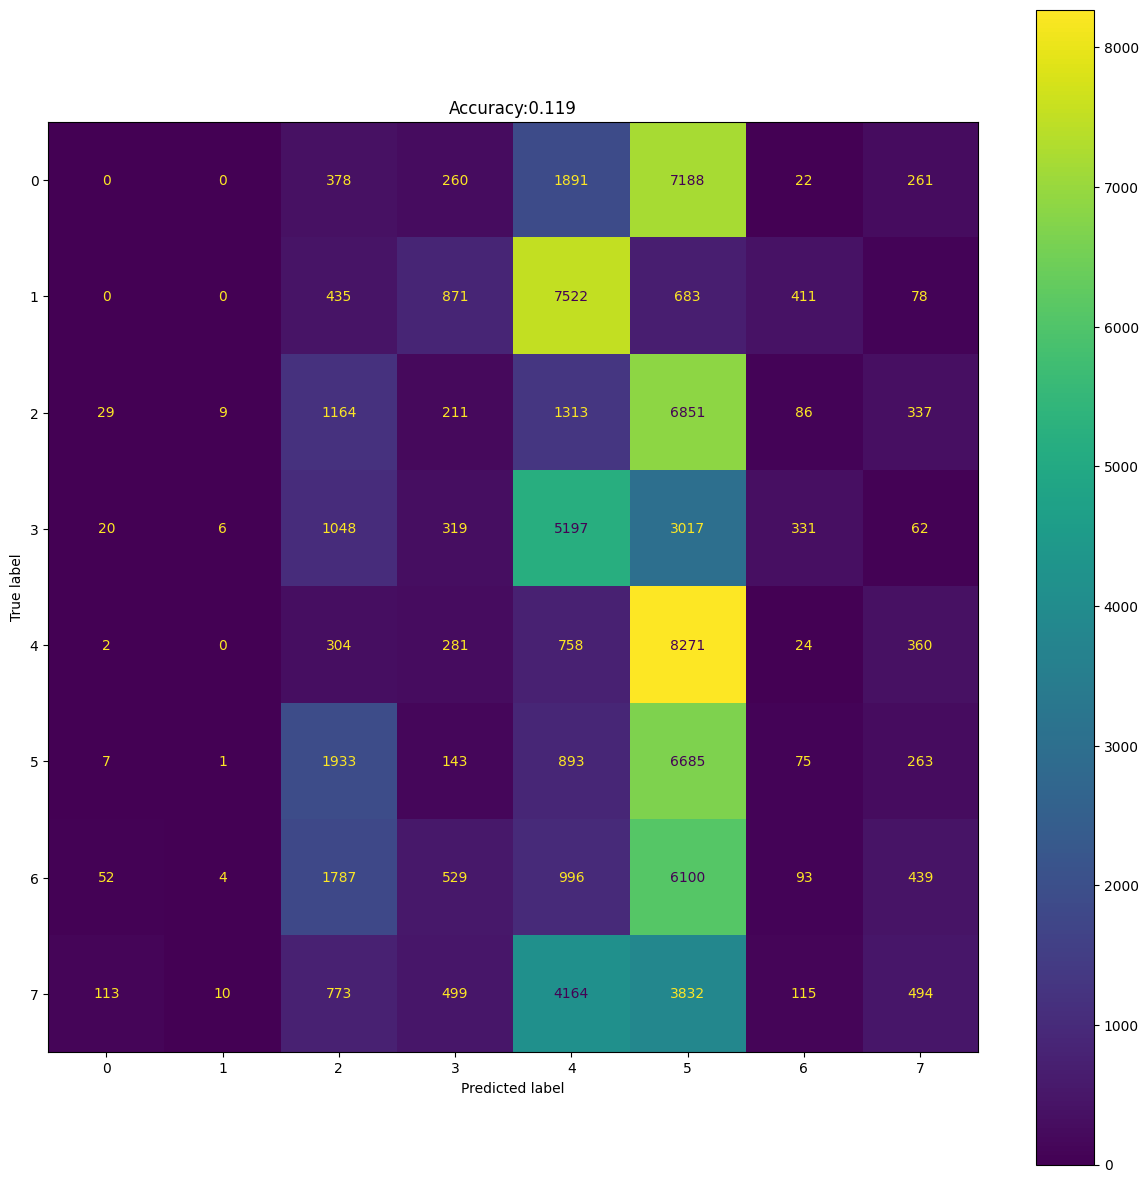

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.9171 - accuracy: 0.1346
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9119 - accuracy: 0.2924
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5850 - accuracy: 0.4075
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4650 - accuracy: 0.4558
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4056 - accuracy: 0.4785
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3683 - accuracy: 0.4929
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3411 - accuracy: 0.5041
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3196 - accuracy: 0.5128
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3018 - accuracy: 0.5195
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

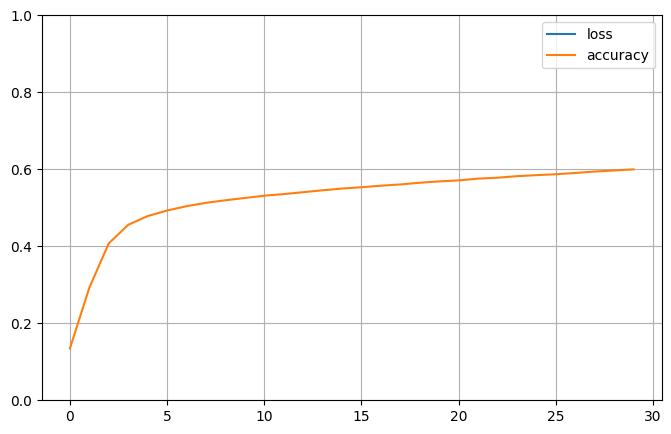

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.1235 - accuracy: 0.6032
test loss, test acc: [1.1235002279281616, 0.6031500101089478]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 6 6 ... 7 7 7]
5
[[5374  147  622  534 1997  836  209  281]
 [  26 9776    4    3   39   24   42   86]
 [ 530   33 4610  940  466 1346 1648  427]
 [ 466   56  541 7199  136  493  410  699]
 [1644   90  421  167 6386  692  280  320]
 [ 787   96 1320  633  918 4709 1222  315]
 [ 280   35 2089  664  439 1466 4268  759]
 [ 386  440  352  992  320  485 1095 5930]]
              precision    recall  f1-score   support

           0       0.57      0.54      0.55     10000
           1       0.92      0.98      0.95     10000
           2       0.46      0.46      0.46     10000
           3       0.65      0.72      0.68     10000
           4       0.60      0.64      0.62     10000
           5       0.47      0.47      0.47     10000
           6       0.47      0.43      0.45     10000
           7       0.67      0.59      0.63     10000

    accuracy                           0.60     80000
   macro avg       0.60      0.60  

Test Accuracy:0.60315


Text(0.5, 1.0, 'Accuracy:0.603')

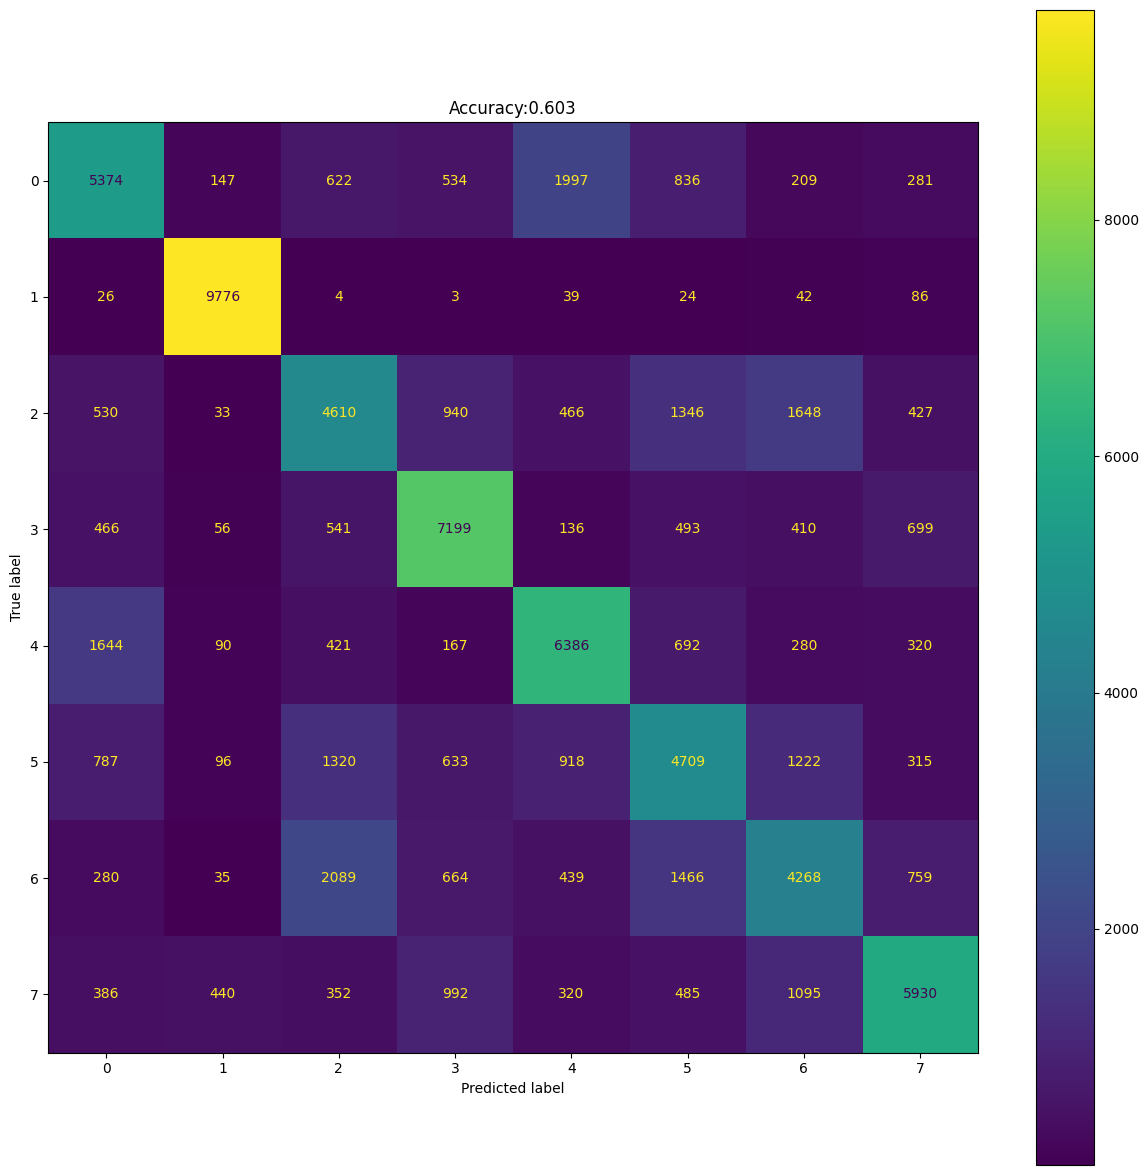

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-30(i) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 5.9390 - accuracy: 0.1952
test loss, test acc: [5.939041614532471, 0.19519999623298645]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 5 0 0]
5
[[7673    0  155    6    0 2166    0    0]
 [  69    0   30    0  464 9352   38   47]
 [3379    0  403   18    0 6198    2    0]
 [4848    0 1207    3    0 3915   27    0]
 [5744    0  160   15    0 4080    1    0]
 [2515    0  207    3    0 7273    2    0]
 [1054    0  369   23    0 8542   10    2]
 [2407    1   86    4   44 7125   79  254]]
              precision    recall  f1-score   support

           0       0.28      0.77      0.41     10000
           1       0.00      0.00      0.00     10000
           2       0.15      0.04      0.06     10000
           3       0.04      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.15      0.73      0.25     10000
           6       0.06      0.00      0.00     10000
           7       0.84      0.03      0.05     10000

    accuracy                           0.20     80000
   macro avg       0.19      0.20  

Test Accuracy:0.1952


Text(0.5, 1.0, 'Accuracy:0.195')

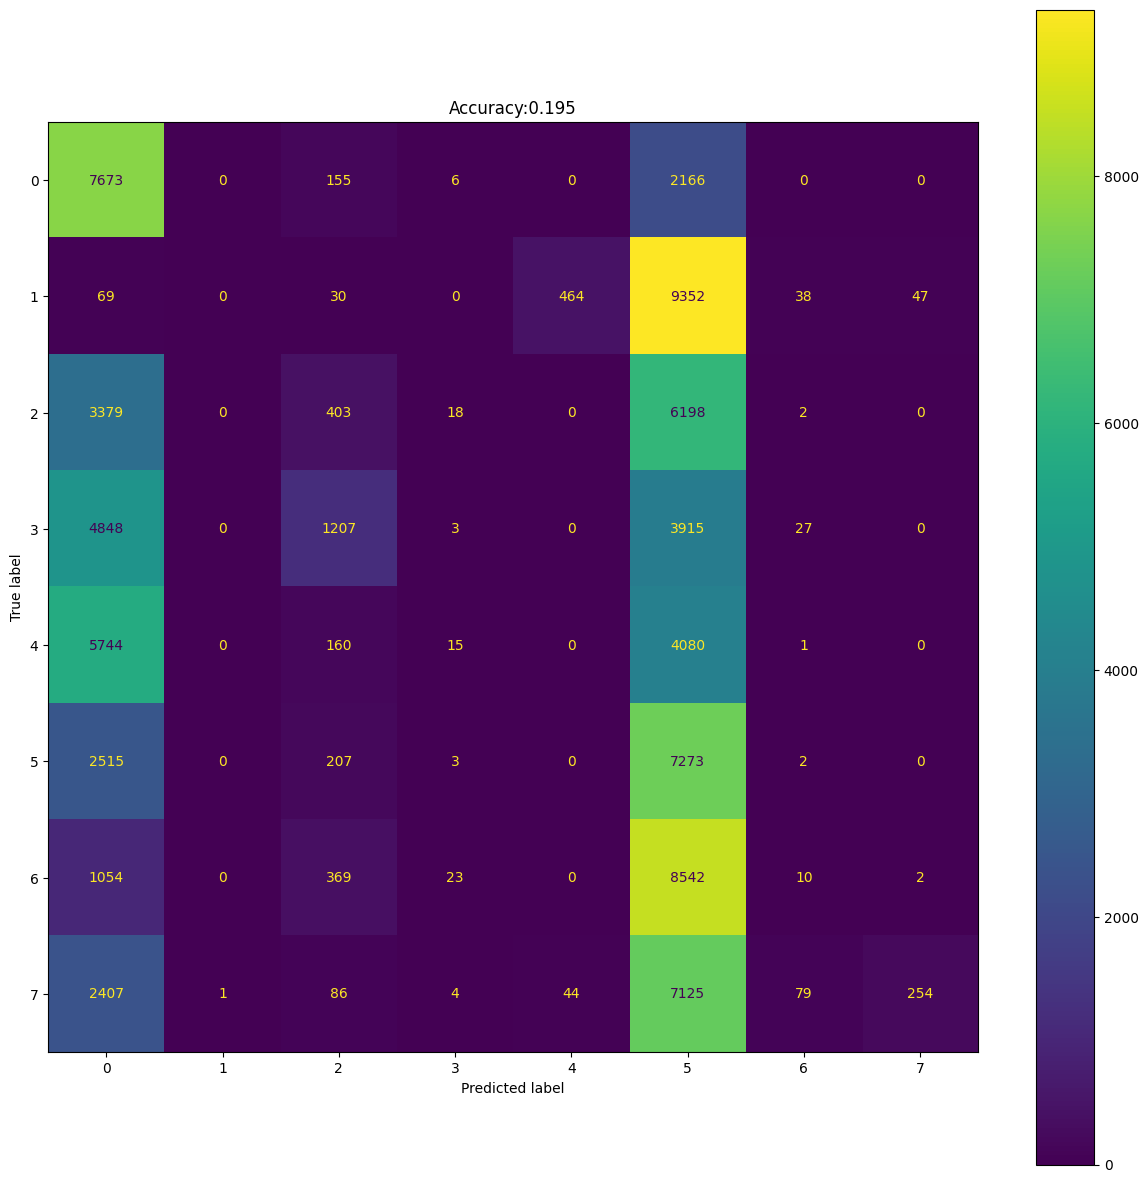

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.3534 - accuracy: 0.2472
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6671 - accuracy: 0.3761
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4814 - accuracy: 0.4444
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3937 - accuracy: 0.4771
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3373 - accuracy: 0.4966
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2948 - accuracy: 0.5136
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2605 - accuracy: 0.5274
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2320 - accuracy: 0.5398
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2070 - accuracy: 0.5495
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

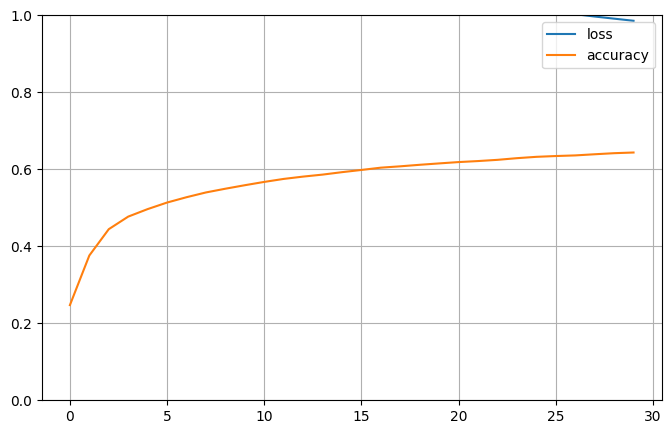

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.9826 - accuracy: 0.6449
test loss, test acc: [0.9825630784034729, 0.6449375152587891]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 7 4 ... 4 7 7]
7
[[6114    0  377  507 1797  845  171  189]
 [   0 9797    0   10    7    2   34  150]
 [ 958    1 3520  821  352 2765 1351  232]
 [ 462    2  255 8061  125  463  519  113]
 [2216    3  179  273 5847  888  284  310]
 [ 821    5 1217  745  676 4893 1265  378]
 [ 290   15 1049  740  394 2041 4934  537]
 [  99  405   51  274  281  153  308 8429]]
              precision    recall  f1-score   support

           0       0.56      0.61      0.58     10000
           1       0.96      0.98      0.97     10000
           2       0.53      0.35      0.42     10000
           3       0.71      0.81      0.75     10000
           4       0.62      0.58      0.60     10000
           5       0.41      0.49      0.44     10000
           6       0.56      0.49      0.52     10000
           7       0.82      0.84      0.83     10000

    accuracy                           0.64     80000
   macro avg       0.64      0.64  

Test Accuracy:0.6449375


Text(0.5, 1.0, 'Accuracy:0.645')

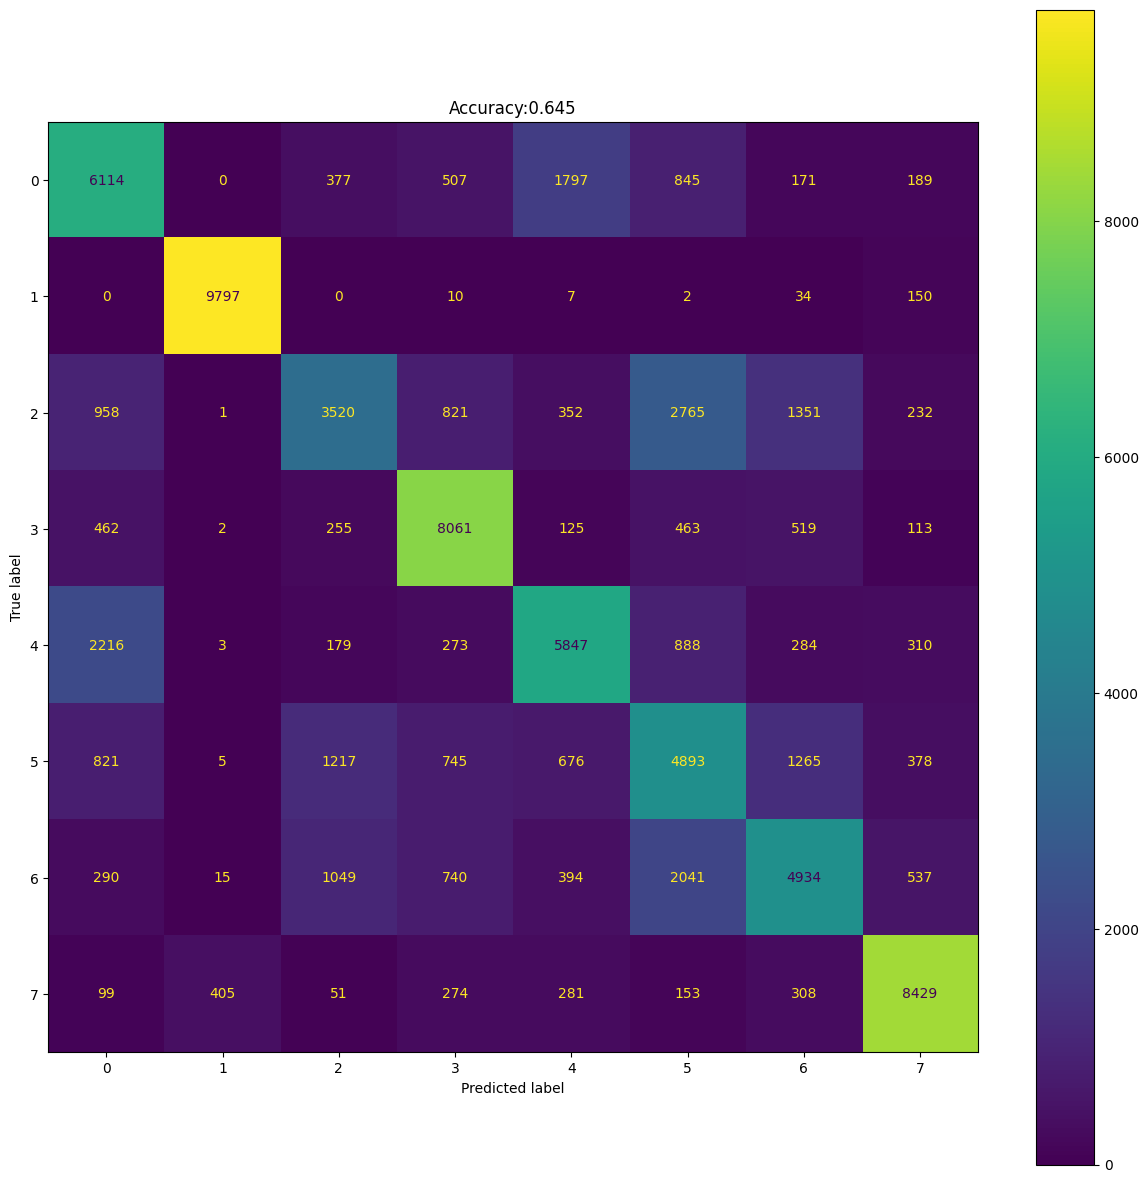

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-30(i) dataset 

In [59]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [60]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.5832 - accuracy: 0.1514
test loss, test acc: [5.5832319259643555, 0.15142500400543213]


In [61]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 3 5 ... 0 0 0]
5
[[5700    0  222  202    0 3821    1   54]
 [4513    4    6 1429 2397  583 1053   15]
 [3167    0  215  134    0 6476    1    7]
 [6610    0  299   15    0 2996   80    0]
 [4373    0  353  351    0 4798    1  124]
 [4120    0  121   40    0 5714    2    3]
 [3979    3  414  125    0 5470    5    4]
 [4771    6  454  391    0 3899   18  461]]
              precision    recall  f1-score   support

           0       0.15      0.57      0.24     10000
           1       0.31      0.00      0.00     10000
           2       0.10      0.02      0.04     10000
           3       0.01      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.17      0.57      0.26     10000
           6       0.00      0.00      0.00     10000
           7       0.69      0.05      0.09     10000

    accuracy                           0.15     80000
   macro avg       0.18      0.15  

Test Accuracy:0.151425


Text(0.5, 1.0, 'Accuracy:0.151')

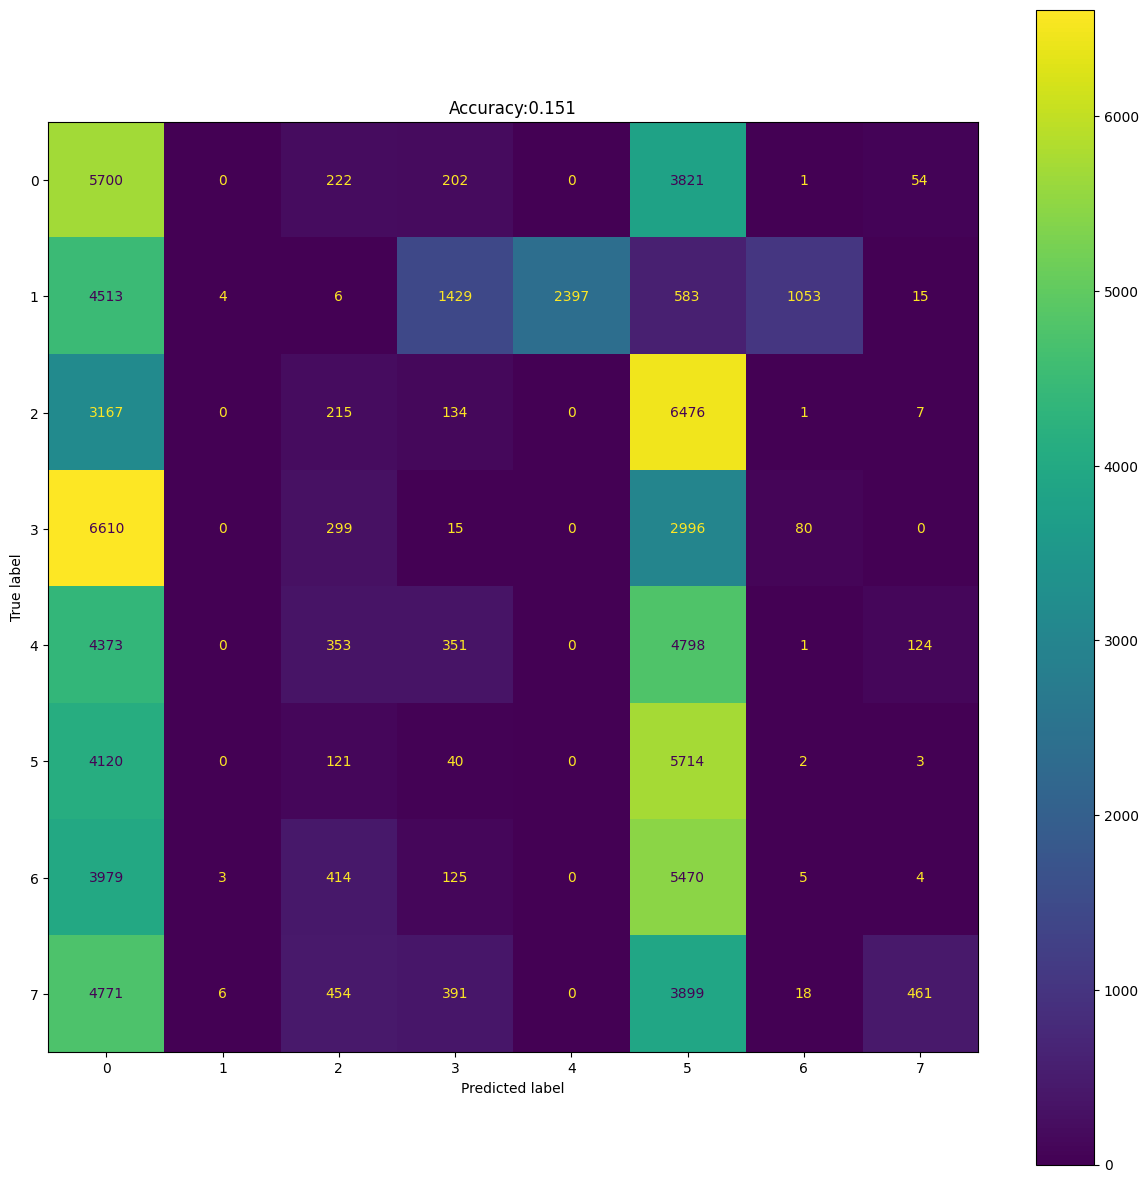

In [62]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [63]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [64]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [65]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.6193 - accuracy: 0.2027
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6713 - accuracy: 0.3847
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4324 - accuracy: 0.4649
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3302 - accuracy: 0.5013
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2728 - accuracy: 0.5237
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2351 - accuracy: 0.5387
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2069 - accuracy: 0.5494
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1846 - accuracy: 0.5595
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1661 - accuracy: 0.5669
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

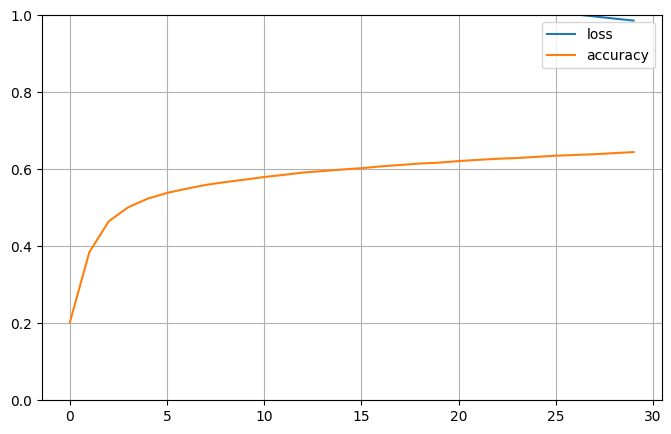

In [66]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [68]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.9837 - accuracy: 0.6447
test loss, test acc: [0.9837421178817749, 0.6446874737739563]


In [69]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 4 7 ... 7 7 7]
7
[[5523    4  474  327 2274 1116  224   58]
 [   2 9848    3    4    0    0    1  142]
 [ 484    4 5620  632  388 1972  749  151]
 [ 291   21  418 7578  116  989  494   93]
 [1848    1  391  223 6160  864  347  166]
 [ 900    2 1575 1069  589 5087  595  183]
 [ 511   14 1753 1197  787 2103 2937  698]
 [  30  173   12  406  220  183  154 8822]]
              precision    recall  f1-score   support

           0       0.58      0.55      0.56     10000
           1       0.98      0.98      0.98     10000
           2       0.55      0.56      0.56     10000
           3       0.66      0.76      0.71     10000
           4       0.58      0.62      0.60     10000
           5       0.41      0.51      0.46     10000
           6       0.53      0.29      0.38     10000
           7       0.86      0.88      0.87     10000

    accuracy                           0.64     80000
   macro avg       0.64      0.64  

Test Accuracy:0.6446875


Text(0.5, 1.0, 'Accuracy:0.645')

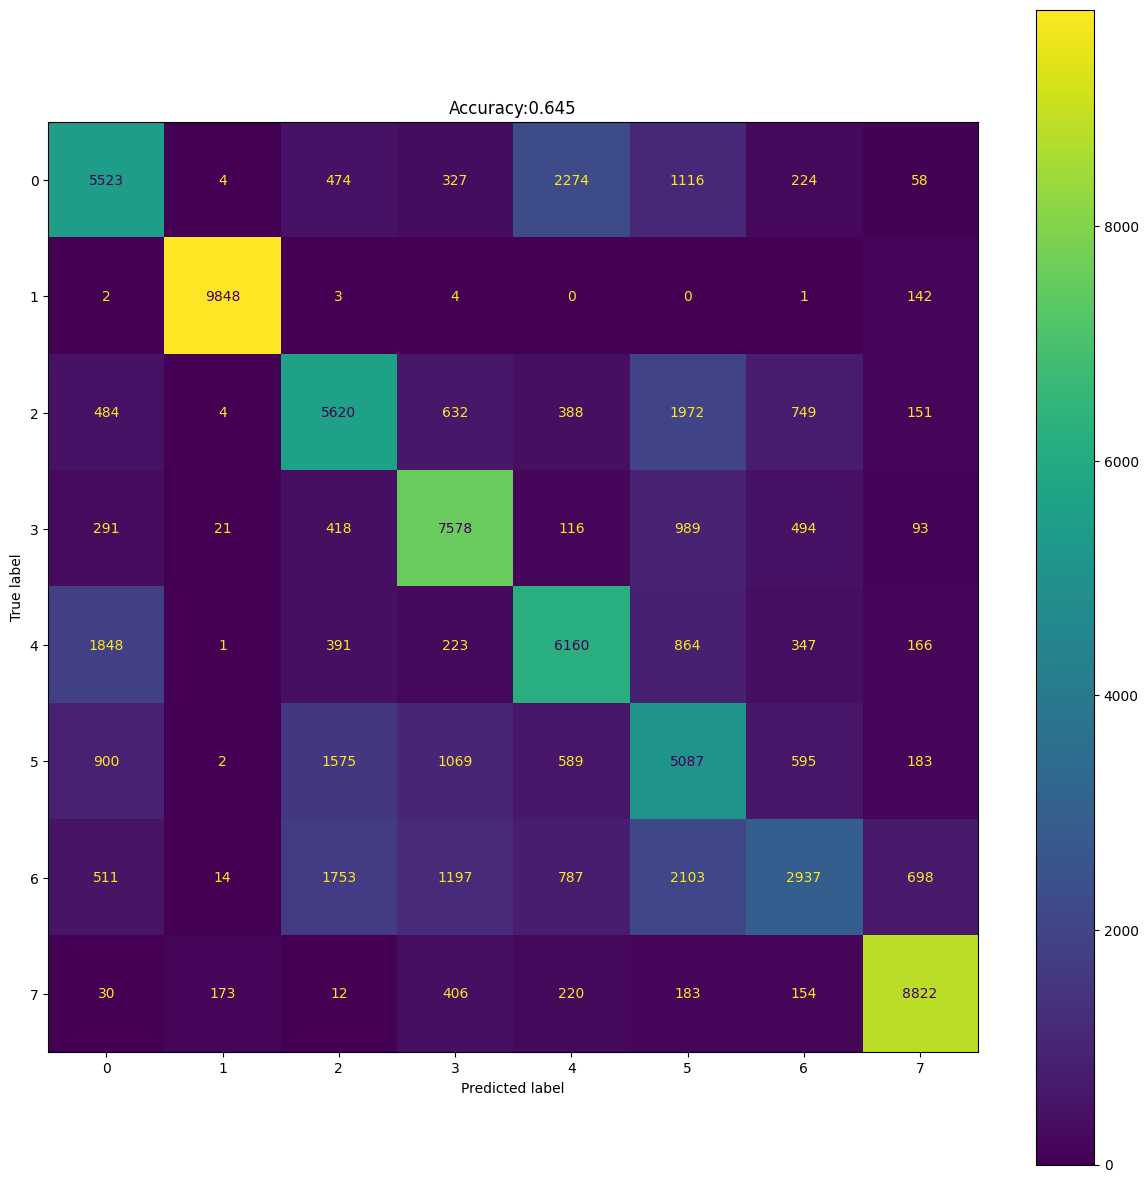

In [70]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')